In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
#from metpy.io import get_test_data


/home/b/b382718/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import gaussian_kde


In [ ]:


ds_nosip = xr.open_mfdataset('/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/nosip/dcmex_2mom_nosip/NWP_*.nc');
ds_4sip = xr.open_mfdataset('/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/control/dcmex_2mom_sip/NWP_*.nc');
ds_nohm = xr.open_mfdataset('/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/nohm/dcmex_2mom_nohm/NWP_*.nc');
ds_norf = xr.open_mfdataset('/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/norf/dcmex_2mom_norf/NWP_*.nc');
ds_nobr = xr.open_mfdataset('/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/nobr/dcmex_2mom_nobr/NWP_*.nc');
ds_nosb = xr.open_mfdataset('/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/nosb/dcmex_2mom_nosb/NWP_*.nc');


In [3]:

grid_dcmex = xr.open_dataset('/work/bk1415/b382718/output/dcmex/nested_run/icon_output/continental_ccn/latent_heat/control/dcmex_2mom_sip/domain4_DOM04.nc');

clon_deg = np.degrees(grid_dcmex.clon)
clat_deg = np.degrees(grid_dcmex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([-107., 34.])
#print(okla_x), print(okla_y)
dx_deg = 0.5; dy_deg = 0.5
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

window_cell = (
    (grid_dcmex.clat >= np.deg2rad(bottom_bound))
    & (grid_dcmex.clat <= np.deg2rad(top_bound))
    & (grid_dcmex.clon >= np.deg2rad(left_bound))
    & (grid_dcmex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_dcmex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_dcmex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)

vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid


-110.03528014751772
-101.96503704937237
30.965910873311245
39.03540077545918
-107.5
-106.5
34.5
33.5
window_vertex_indices :: [  7296   7301   7335 ... 110081 110082 110083]
window_edge_indices :: [ 23554  23555  23556 ... 307870 307871 307872]


In [4]:

new_grid_dcmex = reindex_grid(grid_dcmex, selected_indices, vars_to_renumber)

mask=np.isin(ds_4sip['ncells'], selected_indices.cell)
mask_cell = mask


In [5]:


ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
ds_nosip['tempc'] = ds_nosip.temp-273.16;
ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl

ds_norf['w_vel'] = -1.*ds_norf.omega/(9.8*ds_norf.rho)
ds_norf['tempc'] = ds_norf.temp-273.16;
ds_norf['lwc_gperm3']  = ds_norf.qc*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tqi'] = ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['tq'] = ds_norf.qc+ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
ds_norf['ciwc_gperm3'] = ds_norf.qi*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['tiwc_gperm3'] = (ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh)*ds_norf.rho*1.e3 # kgperm3 to gperm3
ds_norf['cdnc_percm3'] = ds_norf.qnc*ds_norf.rho*1.e-6  # perkg to percm3
ds_norf['inc_perl'] = (ds_norf.qni+ds_norf.qns+ds_norf.qng+ds_norf.qnh)*ds_norf.rho*1.e-3 # perkg to perl

ds_nohm['w_vel'] = -1.*ds_nohm.omega/(9.8*ds_nohm.rho)
ds_nohm['tempc'] = ds_nohm.temp-273.16;
ds_nohm['lwc_gperm3']  = ds_nohm.qc*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tqi'] = ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['tq'] = ds_nohm.qc+ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
ds_nohm['ciwc_gperm3'] = ds_nohm.qi*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['tiwc_gperm3'] = (ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh)*ds_nohm.rho*1.e3 # kgperm3 to gperm3
ds_nohm['cdnc_percm3'] = ds_nohm.qnc*ds_nohm.rho*1.e-6  # perkg to percm3
ds_nohm['inc_perl'] = (ds_nohm.qni+ds_nohm.qns+ds_nohm.qng+ds_nohm.qnh)*ds_nohm.rho*1.e-3 # perkg to perl

ds_nobr['w_vel'] = -1.*ds_nobr.omega/(9.8*ds_nobr.rho)
ds_nobr['tempc'] = ds_nobr.temp-273.16;
ds_nobr['lwc_gperm3']  = ds_nobr.qc*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tqi'] = ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['tq'] = ds_nobr.qc+ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
ds_nobr['ciwc_gperm3'] = ds_nobr.qi*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['tiwc_gperm3'] = (ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh)*ds_nobr.rho*1.e3 # kgperm3 to gperm3
ds_nobr['cdnc_percm3'] = ds_nobr.qnc*ds_nobr.rho*1.e-6  # perkg to percm3
ds_nobr['inc_perl'] = (ds_nobr.qni+ds_nobr.qns+ds_nobr.qng+ds_nobr.qnh)*ds_nobr.rho*1.e-3 # perkg to perl

ds_nosb['w_vel'] = -1.*ds_nosb.omega/(9.8*ds_nosb.rho)
ds_nosb['tempc'] = ds_nosb.temp-273.16;
ds_nosb['lwc_gperm3']  = ds_nosb.qc*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tqi'] = ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['tq'] = ds_nosb.qc+ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
ds_nosb['ciwc_gperm3'] = ds_nosb.qi*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['tiwc_gperm3'] = (ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh)*ds_nosb.rho*1.e3 # kgperm3 to gperm3
ds_nosb['cdnc_percm3'] = ds_nosb.qnc*ds_nosb.rho*1.e-6  # perkg to percm3
ds_nosb['inc_perl'] = (ds_nosb.qni+ds_nosb.qns+ds_nosb.qng+ds_nosb.qnh)*ds_nosb.rho*1.e-3 # perkg to perl


ht_4avg = 1.e-3*ds_4sip.z_mc.mean(dim=('time','ncells'))
tempc_4avg = ds_4sip.tempc.mean(dim=('time','ncells'))


In [6]:

aircraft_starttime='2022-08-02T15:00:00.000000000'
aircraft_endtime='2022-08-03T21:00:00.000000000'

ds_nosip_new = ds_nosip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_4sip_new = ds_4sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_norf_new = ds_norf.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nohm_new = ds_nohm.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nobr_new = ds_nobr.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_nosb_new = ds_nosb.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [126]:



w_thres = 2.
###### Without SIP
# lwc gperm3
#filt_lwc_up = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_dn = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_st = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)

#lwc_up_nosip = filt_lwc_up.mean(dim=('time','ncells'))
#lwc_dn_nosip = filt_lwc_dn.mean(dim=('time','ncells'))
#lwc_st_nosip = filt_lwc_st.mean(dim=('time','ncells'))

#tempc_nosip = ds_nosip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
#filt_tiwc_up = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_dn = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_st = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.tiwc_gperm3, np.nan)

#tiwc_up_nosip = filt_tiwc_up.mean(dim=('time','ncells'))
#tiwc_dn_nosip = filt_tiwc_dn.mean(dim=('time','ncells'))
#tiwc_st_nosip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
#filt_cdnc_up = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_dn = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_st = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.cdnc_percm3, np.nan)

#cdnc_up_nosip = filt_cdnc_up.mean(dim=('time','ncells'))
#cdnc_dn_nosip = filt_cdnc_dn.mean(dim=('time','ncells'))
#cdnc_st_nosip = filt_cdnc_st.mean(dim=('time','ncells'))

# inc gperm3
#filt_inc_up = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_dn = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_st = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.inc_perl, np.nan)

#inc_up_nosip = filt_inc_up.mean(dim=('time','ncells'))
#inc_dn_nosip = filt_inc_dn.mean(dim=('time','ncells'))
#inc_st_nosip = filt_inc_st.mean(dim=('time','ncells'))


###### With SIP
# lwc gperm3
filt_lwc_up = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_dn = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_st = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-9) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)

lwc_up_sip = filt_lwc_up.mean(dim=('time','ncells'))
lwc_dn_sip = filt_lwc_dn.mean(dim=('time','ncells'))
lwc_st_sip = filt_lwc_st.mean(dim=('time','ncells'))

tempc_sip = ds_4sip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_st = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)

tiwc_up_sip = filt_tiwc_up.mean(dim=('time','ncells'))
tiwc_dn_sip = filt_tiwc_dn.mean(dim=('time','ncells'))
tiwc_st_sip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_dn = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_st = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)

cdnc_up_sip = filt_cdnc_up.mean(dim=('time','ncells'))
cdnc_dn_sip = filt_cdnc_dn.mean(dim=('time','ncells'))
cdnc_st_sip = filt_cdnc_st.mean(dim=('time','ncells'))


# inc gperm3
filt_inc_up = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_dn = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
filt_inc_st = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)

inc_up_sip = filt_inc_up.mean(dim=('time','ncells'))
inc_dn_sip = filt_inc_dn.mean(dim=('time','ncells'))
inc_st_sip = filt_inc_st.mean(dim=('time','ncells'))


In [127]:

####================== Boxplot of ICON-LWC [4-SIP]
w_thres = 2.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
lwc_sip_up_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_dn_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_sip_st_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

lwc_sip_up_gperm3 = lwc_sip_up_gperm3.values.flatten()
lwc_sip_dn_gperm3 = lwc_sip_dn_gperm3.values.flatten()
lwc_sip_st_gperm3 = lwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_lwc_sip = pd.DataFrame({
    'lwc_up': lwc_sip_up_gperm3,
    'lwc_dn': lwc_sip_dn_gperm3,
    'lwc_st': lwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_lwc_sip['temp_bin'] = np.digitize(df_lwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_lwc_sip['temp_bin'] = bin_edges[df_lwc_sip['temp_bin']]

df_lwc_up_sip = df_lwc_sip[['lwc_up', 'temp_bin']].dropna()
df_lwc_dn_sip = df_lwc_sip[['lwc_dn', 'temp_bin']].dropna()
df_lwc_st_sip = df_lwc_sip[['lwc_st', 'temp_bin']].dropna()

df_lwc_up_sip = df_lwc_up_sip.dropna(subset=['temp_bin'])
df_lwc_dn_sip = df_lwc_dn_sip.dropna(subset=['temp_bin'])
df_lwc_st_sip = df_lwc_st_sip.dropna(subset=['temp_bin'])

lwc_sip_up_by_bin = [df_lwc_up_sip[df_lwc_up_sip['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
lwc_sip_dn_by_bin = [df_lwc_dn_sip[df_lwc_dn_sip['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
lwc_sip_st_by_bin = [df_lwc_st_sip[df_lwc_st_sip['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]


In [128]:

####================== Boxplot of ICON-CDNC [3-SIP]
w_thres = 2.
thres_q = 1.e-2
###### Without SIP
# lwc gperm3
cdnc_sip_up_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_dn_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_sip_st_percm3 = xr.where((ds_4sip_new.cdnc_percm3 > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)
tempc_sip = ds_4sip_new.tempc

cdnc_sip_up_percm3 = cdnc_sip_up_percm3.values.flatten()
cdnc_sip_dn_percm3 = cdnc_sip_dn_percm3.values.flatten()
cdnc_sip_st_percm3 = cdnc_sip_st_percm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_cdnc_sip = pd.DataFrame({
    'cdnc_up': cdnc_sip_up_percm3,
    'cdnc_dn': cdnc_sip_dn_percm3,
    'cdnc_st': cdnc_sip_st_percm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_cdnc_sip['temp_bin'] = np.digitize(df_cdnc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_cdnc_sip['temp_bin'] = bin_edges[df_cdnc_sip['temp_bin']]

df_cdnc_up_sip = df_cdnc_sip[['cdnc_up', 'temp_bin']].dropna()
df_cdnc_dn_sip = df_cdnc_sip[['cdnc_dn', 'temp_bin']].dropna()
df_cdnc_st_sip = df_cdnc_sip[['cdnc_st', 'temp_bin']].dropna()

df_cdnc_up_sip = df_cdnc_up_sip.dropna(subset=['temp_bin'])
df_cdnc_dn_sip = df_cdnc_dn_sip.dropna(subset=['temp_bin'])
df_cdnc_st_sip = df_cdnc_st_sip.dropna(subset=['temp_bin'])

cdnc_sip_up_by_bin = [df_cdnc_up_sip[df_cdnc_up_sip['temp_bin'] == temp]['cdnc_up'].values for temp in bin_edges]
cdnc_sip_dn_by_bin = [df_cdnc_dn_sip[df_cdnc_dn_sip['temp_bin'] == temp]['cdnc_dn'].values for temp in bin_edges]
cdnc_sip_st_by_bin = [df_cdnc_st_sip[df_cdnc_st_sip['temp_bin'] == temp]['cdnc_st'].values for temp in bin_edges]


In [129]:

####================== Boxplot of ICON-IWC [3-SIP]
w_thres = 2.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
iwc_sip_up_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_dn_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_sip_st_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
tempc_sip = ds_4sip_new.tempc

iwc_sip_up_gperm3 = iwc_sip_up_gperm3.values.flatten()
iwc_sip_dn_gperm3 = iwc_sip_dn_gperm3.values.flatten()
iwc_sip_st_gperm3 = iwc_sip_st_gperm3.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_iwc_sip = pd.DataFrame({
    'iwc_up': iwc_sip_up_gperm3,
    'iwc_dn': iwc_sip_dn_gperm3,
    'iwc_st': iwc_sip_st_gperm3,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_iwc_sip['temp_bin'] = np.digitize(df_iwc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_iwc_sip['temp_bin'] = bin_edges[df_iwc_sip['temp_bin']]

df_iwc_up_sip = df_iwc_sip[['iwc_up', 'temp_bin']].dropna()
df_iwc_dn_sip = df_iwc_sip[['iwc_dn', 'temp_bin']].dropna()
df_iwc_st_sip = df_iwc_sip[['iwc_st', 'temp_bin']].dropna()

df_iwc_up_sip = df_iwc_up_sip.dropna(subset=['temp_bin'])
df_iwc_dn_sip = df_iwc_dn_sip.dropna(subset=['temp_bin'])
df_iwc_st_sip = df_iwc_st_sip.dropna(subset=['temp_bin'])

iwc_sip_up_by_bin = [df_iwc_up_sip[df_iwc_up_sip['temp_bin'] == temp]['iwc_up'].values for temp in bin_edges]
iwc_sip_dn_by_bin = [df_iwc_dn_sip[df_iwc_dn_sip['temp_bin'] == temp]['iwc_dn'].values for temp in bin_edges]
iwc_sip_st_by_bin = [df_iwc_st_sip[df_iwc_st_sip['temp_bin'] == temp]['iwc_st'].values for temp in bin_edges]


In [130]:

####================== Boxplot of ICON-INC [3-SIP]
w_thres = 2.
thres_q = 1.e-4
###### Without SIP
# lwc gperm3
inc_sip_up_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_dn_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
inc_sip_st_perl = xr.where((ds_4sip_new.inc_perl > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)
tempc_sip = ds_4sip_new.tempc

inc_sip_up_perl = inc_sip_up_perl.values.flatten()
inc_sip_dn_perl = inc_sip_dn_perl.values.flatten()
inc_sip_st_perl = inc_sip_st_perl.values.flatten()
tempc_sip = tempc_sip.values.flatten()

df_inc_sip = pd.DataFrame({
    'inc_up': inc_sip_up_perl,
    'inc_dn': inc_sip_dn_perl,
    'inc_st': inc_sip_st_perl,
    'tempc': tempc_sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_inc_sip['temp_bin'] = np.digitize(df_inc_sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_inc_sip['temp_bin'] = bin_edges[df_inc_sip['temp_bin']]

df_inc_up_sip = df_inc_sip[['inc_up', 'temp_bin']].dropna()
df_inc_dn_sip = df_inc_sip[['inc_dn', 'temp_bin']].dropna()
df_inc_st_sip = df_inc_sip[['inc_st', 'temp_bin']].dropna()

df_inc_up_sip = df_inc_up_sip.dropna(subset=['temp_bin'])
df_inc_dn_sip = df_inc_dn_sip.dropna(subset=['temp_bin'])
df_inc_st_sip = df_inc_st_sip.dropna(subset=['temp_bin'])

inc_sip_up_by_bin = [df_inc_up_sip[df_inc_up_sip['temp_bin'] == temp]['inc_up'].values for temp in bin_edges]
inc_sip_dn_by_bin = [df_inc_dn_sip[df_inc_dn_sip['temp_bin'] == temp]['inc_dn'].values for temp in bin_edges]
inc_sip_st_by_bin = [df_inc_st_sip[df_inc_st_sip['temp_bin'] == temp]['inc_st'].values for temp in bin_edges]


In [131]:


file = open('/work/bb1163/b382718/output/dcmex/observations/airborne_inp/02_INP_data_teflon.csv'); 

data_teflon_inp = pd.read_csv('/work/bb1163/b382718/output/dcmex/observations/airborne_inp/02_INP_data_teflon.csv');
data_polycar_inp = pd.read_csv('/work/bb1163/b382718/output/dcmex/observations/airborne_inp/03_INP_data_polycarbonate.csv');

#print(data_teflon_inp)
sample_tef = data_teflon_inp['Sample'];
drop_freeze_tef_temp_degC = data_teflon_inp['Droplet freezing temp'];
fract_frozen = data_teflon_inp['Fraction frozen'];
teflon_inp_perl = data_teflon_inp['INP(L-1)'];
upper_error_inp = data_teflon_inp['INP upper error bar'];
lower_error_inp = data_teflon_inp['INP lower error bar'];

sample_polycar = data_polycar_inp['Sample'];
drop_freeze_polycar_temp_degC = data_polycar_inp['Droplet freezing temp'];
fract_frozen = data_polycar_inp['Fraction frozen'];
polycar_inp_perl = data_polycar_inp['INP(L-1)'];
polycar_upper_error_inp = data_polycar_inp['INP upper error bar'];
polycar_lower_error_inp = data_polycar_inp['INP lower error bar'];


In [132]:


temp_bin = [0., -2., -4., -6., -8., -10., -12., -14., -16., -18., -20., -22., -24., -26., -28., -30., -32., -34., -36.];

mean_tef_inp_perl = []; tef_inp_med = []; tef_inp_std_dev = [];
for i in range(len(temp_bin)-1):
    mask = (drop_freeze_tef_temp_degC >= temp_bin[i+1]) & (drop_freeze_tef_temp_degC < temp_bin[i])
    mean_tef_inp_perl.append(np.mean(teflon_inp_perl[mask]))
    tef_inp_med.append(np.nanmedian(mean_tef_inp_perl))
    tef_inp_std_dev.append(np.nanstd(mean_tef_inp_perl))


# Calculate statistics
tef_inp_std_err = tef_inp_std_dev/np.sqrt(len(mean_tef_inp_perl))

mean_polycar_inp_perl = []; polycar_inp_med = []; polycar_inp_std_dev = [];
for i in range(len(temp_bin)-1):
    mask = (drop_freeze_polycar_temp_degC >= temp_bin[i+1]) & (drop_freeze_polycar_temp_degC < temp_bin[i])
    mean_polycar_inp_perl.append(np.mean(polycar_inp_perl[mask]))
    polycar_inp_med.append(np.nanmedian(mean_polycar_inp_perl))
    polycar_inp_std_dev.append(np.nanstd(mean_polycar_inp_perl))


# Calculate statistics
tef_inp_std_err = tef_inp_std_dev/np.sqrt(len(mean_tef_inp_perl))


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [133]:
import h5py

# Open the NetCDF file using h5py
with h5py.File('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v601_r0_c310.nc', 'r') as f:
    # Print all group names in the file
    print(f.visititems(lambda name, obj: print(name)))

aimms
aimms/aimms_altitude
aimms/aimms_angle_of_attack
aimms/aimms_angle_of_sideslip
aimms/aimms_course
aimms/aimms_flag
aimms/aimms_ground_speed
aimms/aimms_heading
aimms/aimms_latitude
aimms/aimms_longitude
aimms/aimms_pitch
aimms/aimms_pressure
aimms/aimms_roll
aimms/aimms_true_air_speed
aimms/aimms_u
aimms/aimms_v
aimms/aimms_velocity_east
aimms/aimms_velocity_north
aimms/aimms_vertical_velocity
aimms/aimms_w
aimms/aimms_wind_direction
aimms/aimms_wind_speed
aimms/sps20
altitude
cdp
cdp/cdp_bin_centre
cdp/cdp_bin_width
cdp/cdp_conc
cdp/cdp_conc_psd
cdp/cdp_flag
cdp/cdp_lwc
cdp/cdp_lwc_dbz
cdp/cdp_rain_rate
cip_100
cip_100/cip100_bin_centre
cip_100/cip100_bin_width
cip_100/cip100_flag
cip_100/cip100_ovld
cip_100/pads
cip_100/pads/cip100_conc_psd_pads
cip_100/pads/cip100_ed_pads
cip_100/pads/cip100_lwc_pads
cip_100/pads/cip100_mvd_pads
cip_100/processed
cip_100/processed/cip100_edge_psd
cip_100/processed/cip100_iwc_dbz
cip_100/processed/cip100_iwc_psd
cip_100/processed/cip100_lwc_dbz

In [134]:
####################### Aircraft observation analysis #######################
import netCDF4

data_faam_core_cld_phy_latlon = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v602_r1_c310.nc');
data_faam_core_cld_phy = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v503_r1_c310.nc')
#print(data_faam_core.time)

time_faam_core_cld_phy = data_faam_core_cld_phy['Time'];
lon_faam_core_cld_phy = data_faam_core_cld_phy_latlon['longitude'];
lat_faam_core_cld_phy = data_faam_core_cld_phy_latlon['latitude'];
alt_faam_core_cld_phy = data_faam_core_cld_phy_latlon['altitude'];
#cdp_conc_faam_core_cld_phy = data_faam_core_cld_phy['cdp_conc'];
#print(time_faam_core)
print('')
data_faam_hvps = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-hvps_faam_20220802_v001_r0_c310.nc');
data_faam_cpi  = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-cpi_faam_20220802_v001_c310.nc');
data_faam_2ds  = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-2ds_faam_20220802_v001_r0_c310.nc')
data_faam_core = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core_faam_20220802_v005_r0_c310.nc');

data_faam_nevrozov = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/metoffice-nevzorov_faam_20220802_r0_c310_1hz.nc');
data_faam_core_1hz = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core_faam_20220802_v005_r0_c310_1hz.nc');


time = pd.to_datetime(data_faam_cpi['time'].values)
new_time = time.map(lambda t: t.replace(year=2022,day=2))
data_faam_cpi['time'] = new_time

time_cpi = pd.to_datetime(data_faam_cpi['time'].values)

# Set the nanoseconds part to zero (resetting microseconds/nanoseconds to 0)
new_time = time_cpi.map(lambda t: t.replace(microsecond=0, nanosecond=0))

# Update the time coordinate in the DataArray
data_faam_cpi['time'] = new_time


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/pdcompat.py:104: FutureWarning: Parsed string "2023/08/03 13:01:50.01S" included an un-recognized timezone "S". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  return pd.Timestamp(*args, **kwargs).as_unit("ns")
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/pdcompat.py:104: FutureWarning: Parsed string "2023/08/03 13:01:50.01S" included an un-recognized timezone "S". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  return pd.Timestamp(*args, **kwargs).as_unit("ns")


In [135]:

import matplotlib.patches as mpatches

# Validating total ice number concentrations

file_cip = '/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/core-cloud-phy_faam_20220802_v602_r1_c310.nc'
ds_cip15 = xr.open_mfdataset(file_cip, group='cip_15/processed');
ds_cip100 = xr.open_mfdataset(file_cip, group='cip_100/processed');

ds_cip15['cip15_conc_bin_perl'] = ds_cip15['cip15_iwc_psd'].where(ds_cip15['cip15_iwc_psd'] != 0, np.nan)
ds_cip100['cip100_conc_bin_perl'] = ds_cip100['cip100_iwc_psd'].where(ds_cip100['cip100_iwc_psd'] != 0, np.nan)

# sum over all diameter bins
ds_cip15['tot_cip15_perl'] = ds_cip15.cip15_conc_bin_perl.sum(dim=('cip15_bin_centre'))
ds_cip100['tot_cip100_perl'] = ds_cip100.cip100_conc_bin_perl.sum(dim=('cip100_bin_centre'))

# merge cip100 and cip15
ds_cip_new = xr.merge([ds_cip15, ds_cip100])

# total cip concentrations
ds_cip_new['tot_inc_perl'] = ds_cip15['tot_cip15_perl']+ds_cip100['tot_cip100_perl']

# Need to extract temperature from core data
data_faam_core_1hz_new = data_faam_core_1hz

# ds_cip has 'time' and data_faam_core_1hz has 'Time', make it the same
data_faam_core_1hz_new = data_faam_core_1hz_new.rename({'Time': 'time'})

# CIP ice concentrations in updraft, downdraft and stratiform regions 
ds_cip_new['TAT_DI_R'] = data_faam_core_1hz_new['TAT_DI_R']
ds_cip_new['W_C'] = data_faam_core_1hz_new['W_C']
ds_cip_new['tempc'] = ds_cip_new['TAT_DI_R']-273.16

# create conditions
filt_cip15_up_cond = (ds_cip_new.tot_cip15_perl > 0.) & (ds_cip_new.W_C > 1.)
filt_cip15_dn_cond = (ds_cip_new.tot_cip15_perl > 0.) & (ds_cip_new.W_C < 1.)
filt_cip15_st_cond = (ds_cip_new.tot_cip15_perl > 0.) & (np.abs(ds_cip_new.W_C) < 1.)

filt_cip100_up_cond = (ds_cip_new.tot_cip100_perl > 0.) & (ds_cip_new.W_C > 1.)
filt_cip100_dn_cond = (ds_cip_new.tot_cip100_perl > 0.) & (ds_cip_new.W_C < 1.)
filt_cip100_st_cond = (ds_cip_new.tot_cip100_perl > 0.) & (np.abs(ds_cip_new.W_C) < 1.)

filt_totcip_up_cond = (ds_cip_new.tot_inc_perl > 0.) & (ds_cip_new.W_C > 1.)
filt_totcip_dn_cond = (ds_cip_new.tot_inc_perl > 0.) & (ds_cip_new.W_C < -1.)
filt_totcip_st_cond = (ds_cip_new.tot_inc_perl > 0.) & (np.abs(ds_cip_new.W_C) < 1.)

# store variables
ds_cip_new['tot_cip15_up_perl'] = xr.where(filt_cip15_up_cond, ds_cip_new.tot_cip15_perl, np.nan)
ds_cip_new['tot_cip15_dn_perl'] = xr.where(filt_cip15_dn_cond, ds_cip_new.tot_cip15_perl, np.nan)
ds_cip_new['tot_cip15_st_perl'] = xr.where(filt_cip15_st_cond, ds_cip_new.tot_cip15_perl, np.nan)

ds_cip_new['tot_cip100_up_perl'] = xr.where(filt_cip100_up_cond, ds_cip_new.tot_cip100_perl, np.nan)
ds_cip_new['tot_cip100_dn_perl'] = xr.where(filt_cip100_dn_cond, ds_cip_new.tot_cip100_perl, np.nan)
ds_cip_new['tot_cip100_st_perl'] = xr.where(filt_cip100_st_cond, ds_cip_new.tot_cip100_perl, np.nan)

ds_cip_new['tot_inc_up_perl'] = xr.where(filt_totcip_up_cond, ds_cip_new.tot_inc_perl, np.nan)
ds_cip_new['tot_inc_dn_perl'] = xr.where(filt_totcip_dn_cond, ds_cip_new.tot_inc_perl, np.nan)
ds_cip_new['tot_inc_st_perl'] = xr.where(filt_totcip_st_cond, ds_cip_new.tot_inc_perl, np.nan)

# Define temperature bins
#temp_cip_bin = np.array([0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_cip_bin = np.arange(-20, 20, 5)
temp_cip_bin = np.sort(temp_cip_bin)

tempc_values = ds_cip_new['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_cip_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_cip_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_cip_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_cip_new['tempc'].coords['time']
ds_cip_new['temp_cip_bin'] = xr.DataArray(temp_bin_labels_full, coords={'time': time_coord}, dims=['time'])

df_up_cip = ds_cip_new[['tot_inc_up_perl', 'temp_cip_bin']].to_dataframe().dropna()
df_dn_cip = ds_cip_new[['tot_inc_dn_perl', 'temp_cip_bin']].to_dataframe().dropna()
df_st_cip = ds_cip_new[['tot_inc_st_perl', 'temp_cip_bin']].to_dataframe().dropna()

df_up_cip = df_up_cip.dropna(subset=['temp_cip_bin'])
df_dn_cip = df_dn_cip.dropna(subset=['temp_cip_bin'])
df_st_cip = df_st_cip.dropna(subset=['temp_cip_bin'])

# Sort the data by bin
inc_cip_up_by_bin = [df_up_cip[df_up_cip['temp_cip_bin'] == temp]['tot_inc_up_perl'].values for temp in temp_cip_bin]
inc_cip_dn_by_bin = [df_dn_cip[df_dn_cip['temp_cip_bin'] == temp]['tot_inc_dn_perl'].values for temp in temp_cip_bin]
inc_cip_st_by_bin = [df_st_cip[df_st_cip['temp_cip_bin'] == temp]['tot_inc_st_perl'].values for temp in temp_cip_bin]


In [136]:

# for the operation below, see the ncdump -h mas-2ds_faam_20220802*.nc and emails by Blyth and Finney

twods = xr.Dataset({"time": ("time", pd.date_range("1970-01-01", periods=14604, freq="S"))})
attrs = {"description": "Adjusted time values", "source": "Generated by script"}

ts = xr.Dataset({"time": ("time", twods['time'].values + pd.Timedelta(1659454542.,unit='s'), attrs)})
twods['time'] = ts['time']

ds_2ds  = xr.open_mfdataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/man-2ds_faam_20220802_v001_r0_c310.nc', group='ch1')
ds_2ds['time'] = ts['time']

# Total ice concentrations
ds_2ds['tot_inc_perl'] = ds_2ds.total_number_concentration_of_ambient_MI_particles_in_air + ds_2ds.total_number_concentration_of_ambient_HI_particles_in_air


time_2ds = pd.to_datetime(ds_2ds['time'].values)
time_core = pd.to_datetime(data_faam_core_1hz_new['time'].values)

common_times = time_2ds[time_2ds.isin(time_core)]

# Now select data_faam_cpi where time is in common_times
ds_core_1hz_new = data_faam_core_1hz_new.sel(time=common_times)
ds_2ds_new = ds_2ds.sel(time=common_times)

#ds_2ds_new = xr.merge([ds_faam_1hz_2ds, ds_2ds])
ds_2ds_new['TAT_DI_R'] = ds_core_1hz_new['TAT_DI_R']
ds_2ds_new['W_C'] = ds_core_1hz_new['W_C']
ds_2ds_new['TAS'] = ds_core_1hz_new['TAS']
ds_2ds_new['tempc'] = ds_2ds_new['TAT_DI_R']-273.16

# As per Alan Blyth and Finney, UniLeeds (see emails)
ds_2ds_new['tot_inc_perl'] = ds_2ds_new['tot_inc_perl']*60./ds_2ds_new.TAS 

# Profiles for the updrafts, downdrafts and stratiform regions
filt_tot2ds_up_cond = (ds_2ds_new.tot_inc_perl > 0.) & (ds_2ds_new.W_C > 1.)
filt_tot2ds_dn_cond = (ds_2ds_new.tot_inc_perl > 0.) & (ds_2ds_new.W_C < -1.)
filt_tot2ds_st_cond = (ds_2ds_new.tot_inc_perl > 0.) & (np.abs(ds_2ds_new.W_C) < 1.)

# store variables
ds_2ds_new['tot_inc_up_perl'] = xr.where(filt_tot2ds_up_cond, ds_2ds_new.tot_inc_perl, np.nan)
ds_2ds_new['tot_inc_dn_perl'] = xr.where(filt_tot2ds_dn_cond, ds_2ds_new.tot_inc_perl, np.nan)
ds_2ds_new['tot_inc_st_perl'] = xr.where(filt_tot2ds_st_cond, ds_2ds_new.tot_inc_perl, np.nan)

# Define temperature bins
#temp_2ds_bin = np.array([0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_2ds_bin = np.arange(-20, 20, 5)
temp_2ds_bin = np.sort(temp_2ds_bin)

tempc_values = ds_2ds_new['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_2ds_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_2ds_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_2ds_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_2ds_new['tempc'].coords['time']
ds_2ds_new['temp_2ds_bin'] = xr.DataArray(temp_bin_labels_full, coords={'time': time_coord}, dims=['time'])

df_up_2ds = ds_2ds_new[['tot_inc_up_perl', 'temp_2ds_bin']].to_dataframe().dropna()
df_dn_2ds = ds_2ds_new[['tot_inc_dn_perl', 'temp_2ds_bin']].to_dataframe().dropna()
df_st_2ds = ds_2ds_new[['tot_inc_st_perl', 'temp_2ds_bin']].to_dataframe().dropna()

df_up_2ds = df_up_2ds.dropna(subset=['temp_2ds_bin'])
df_dn_2ds = df_dn_2ds.dropna(subset=['temp_2ds_bin'])
df_st_2ds = df_st_2ds.dropna(subset=['temp_2ds_bin'])

# Sort the data by bin
inc_2ds_up_by_bin = [df_up_2ds[df_up_2ds['temp_2ds_bin'] == temp]['tot_inc_up_perl'].values for temp in temp_2ds_bin]
inc_2ds_dn_by_bin = [df_dn_2ds[df_dn_2ds['temp_2ds_bin'] == temp]['tot_inc_dn_perl'].values for temp in temp_2ds_bin]
inc_2ds_st_by_bin = [df_st_2ds[df_st_2ds['temp_2ds_bin'] == temp]['tot_inc_st_perl'].values for temp in temp_2ds_bin]


/tmp/ipykernel_2642268/1572104635.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  twods = xr.Dataset({"time": ("time", pd.date_range("1970-01-01", periods=14604, freq="S"))})


In [139]:

filt_inc_up_perl = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel > 1.), ds_4sip_new.inc_perl, np.nan)
filt_inc_dn_perl = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (ds_4sip_new.w_vel < -1.), ds_4sip_new.inc_perl, np.nan)
filt_inc_st_perl = xr.where((ds_4sip_new.inc_perl > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < 1.), ds_4sip_new.inc_perl, np.nan)

tinc_up_2mom = filt_inc_up_perl.mean(dim=('time','ncells'))
tinc_dn_2mom = filt_inc_dn_perl.mean(dim=('time','ncells'))
tinc_st_2mom = filt_inc_st_perl.mean(dim=('time','ncells'))

tempc_2mom = ds_4sip_new.tempc.mean(dim=('time','ncells'))


/tmp/ipykernel_2642268/1188729118.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)
/tmp/ipykernel_2642268/1188729118.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)
/tmp/ipykernel_2642268/1188729118.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)


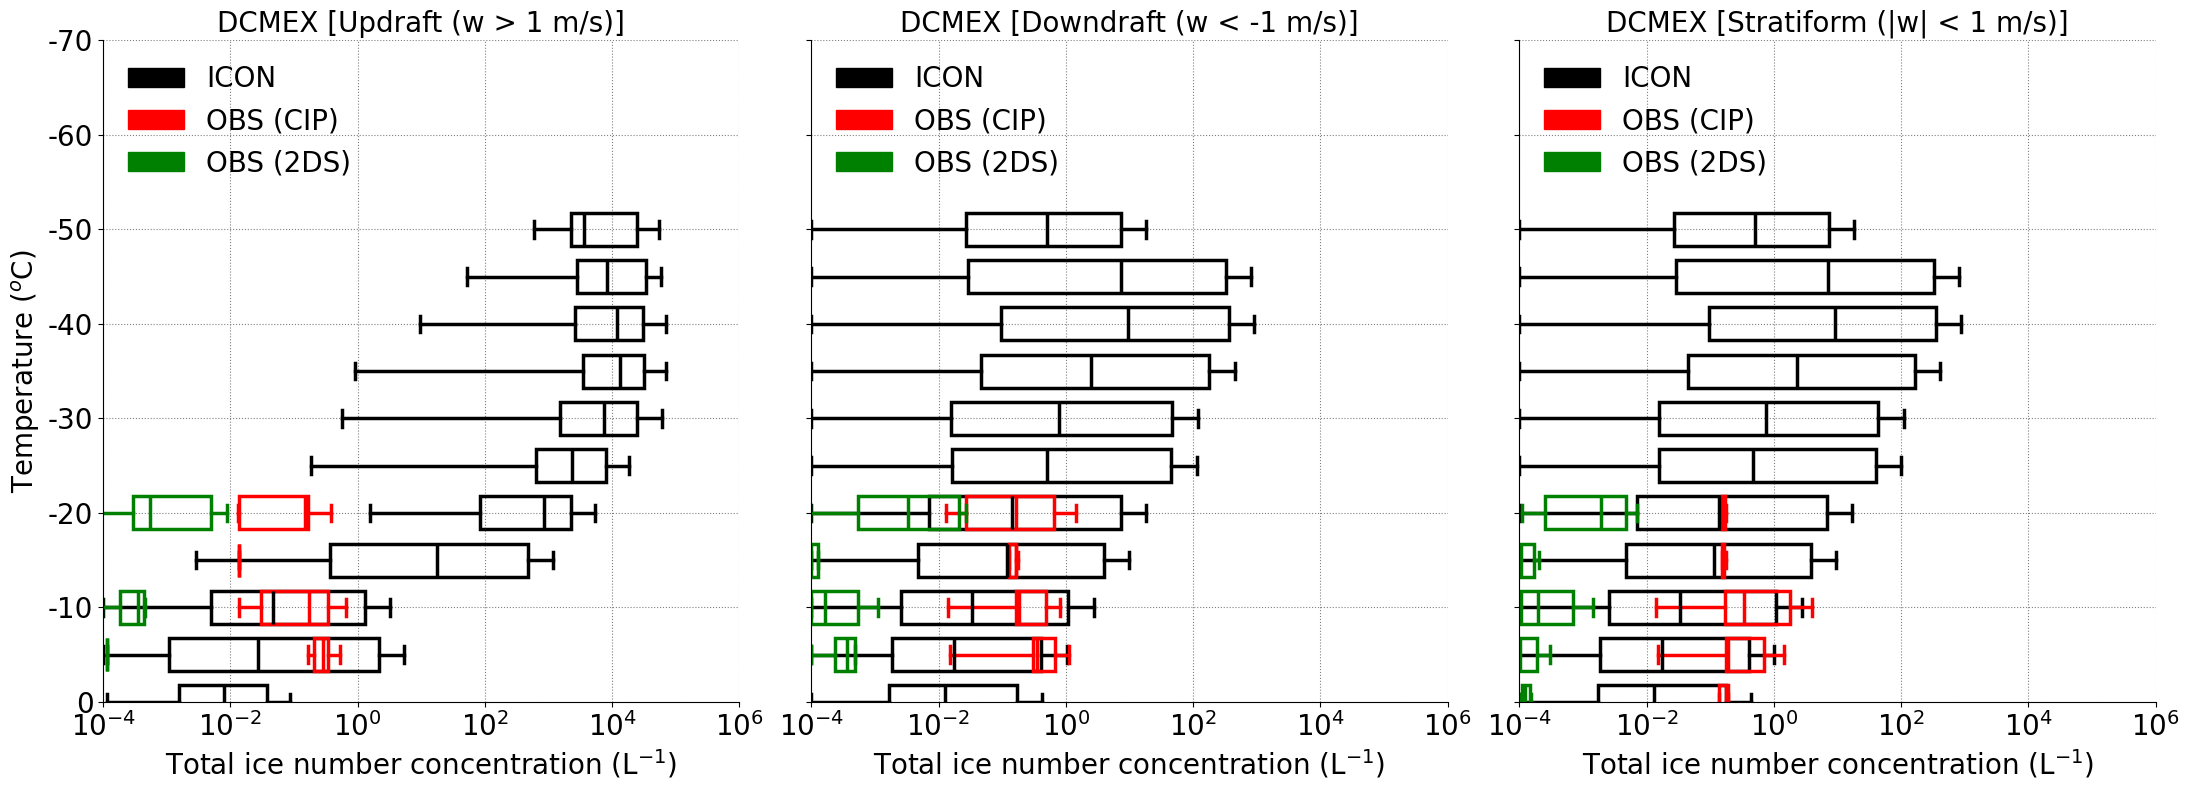

In [141]:


fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(tinc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_up_by_bin, positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_2ds_up_by_bin, positions=temp_2ds_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(tinc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_dn_by_bin, positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_2ds_dn_by_bin, positions=temp_2ds_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)
        
    elif i == 2:
        #ax.plot(tinc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(inc_cip_st_by_bin, positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
        ax.boxplot(inc_2ds_st_by_bin, positions=temp_2ds_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='green', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='green', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='green', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='green', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e6)
    ax.set_xticklabels([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], fontsize=fontsize)
    ax.set_ylim(0, -70)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha1)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CIP)')
    obs_patch3 = mpatches.Patch(color='green', label='OBS (2DS)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2, obs_patch3], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


In [142]:

time_nev = pd.to_datetime(data_faam_nevrozov['Time'].values)
time_core = pd.to_datetime(data_faam_core_1hz['Time'].values)

common_times = time_nev[time_nev.isin(time_core)]

# Now select data_faam_cpi where time is in common_times
#ds_core_1hz_new = data_faam_core_1hz_new.sel(time=common_times)

ds_faam_core_new = data_faam_core_1hz.sel(Time=common_times)
ds_nev_new = data_faam_nevrozov.sel(Time=common_times)

ds_nev_new = xr.merge([ds_faam_core_new, ds_nev_new])

ds_nev_new['tempc'] = ds_nev_new['TAT_DI_R']-273.16


filt_lwc_nev_up_cond = (ds_nev_new.LWC1 > 1.e-6) & (ds_nev_new.W_C > 1.)
filt_lwc_nev_dn_cond = (ds_nev_new.LWC1 > 1.e-6) & (ds_nev_new.W_C < -1.)
filt_lwc_nev_st_cond = (ds_nev_new.LWC1 > 1.e-6) & (np.abs(ds_nev_new.W_C) < 1.)

filt_iwc_nev_up_cond = (ds_nev_new.IWC1 > 1.e-6) & (ds_nev_new.W_C > 1.)
filt_iwc_nev_dn_cond = (ds_nev_new.IWC1 > 1.e-6) & (ds_nev_new.W_C < -1.)
filt_iwc_nev_st_cond = (ds_nev_new.IWC1 > 1.e-6) & (np.abs(ds_nev_new.W_C) < 1.)

# store variables
ds_nev_new['lwc_up_gperm3'] = xr.where(filt_lwc_nev_up_cond, ds_nev_new.LWC1, np.nan)
ds_nev_new['lwc_dn_gperm3'] = xr.where(filt_lwc_nev_dn_cond, ds_nev_new.LWC1, np.nan)
ds_nev_new['lwc_st_gperm3'] = xr.where(filt_lwc_nev_st_cond, ds_nev_new.LWC1, np.nan)

ds_nev_new['iwc_up_gperm3'] = xr.where(filt_iwc_nev_up_cond, ds_nev_new.IWC1, np.nan)
ds_nev_new['iwc_dn_gperm3'] = xr.where(filt_iwc_nev_dn_cond, ds_nev_new.IWC1, np.nan)
ds_nev_new['iwc_st_gperm3'] = xr.where(filt_iwc_nev_st_cond, ds_nev_new.IWC1, np.nan)

# Define temperature bins
#temp_nev_bin = np.array([30., 27., 24., 21., 18., 15., 12., 9., 6., 3., 0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])

temp_nev_bin = np.arange(-30, 30, 5)
temp_nev_bin = np.sort(temp_nev_bin)

tempc_values = ds_nev_new['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_nev_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_nev_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_nev_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_nev_new['tempc'].coords['Time']
ds_nev_new['temp_nev_bin'] = xr.DataArray(temp_bin_labels_full, coords={'Time': time_coord}, dims=['Time'])

df_up_lwc_nev = ds_nev_new[['lwc_up_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_dn_lwc_nev = ds_nev_new[['lwc_dn_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_st_lwc_nev = ds_nev_new[['lwc_st_gperm3', 'temp_nev_bin']].to_dataframe().dropna()

df_up_iwc_nev = ds_nev_new[['iwc_up_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_dn_iwc_nev = ds_nev_new[['iwc_dn_gperm3', 'temp_nev_bin']].to_dataframe().dropna()
df_st_iwc_nev = ds_nev_new[['iwc_st_gperm3', 'temp_nev_bin']].to_dataframe().dropna()

df_up_lwc_nev = df_up_lwc_nev.dropna(subset=['temp_nev_bin'])
df_dn_lwc_nev = df_dn_lwc_nev.dropna(subset=['temp_nev_bin'])
df_st_lwc_nev = df_st_lwc_nev.dropna(subset=['temp_nev_bin'])

df_up_iwc_nev = df_up_iwc_nev.dropna(subset=['temp_nev_bin'])
df_dn_iwc_nev = df_dn_iwc_nev.dropna(subset=['temp_nev_bin'])
df_st_iwc_nev = df_st_iwc_nev.dropna(subset=['temp_nev_bin'])

# Sort the data by bin
lwc_nev_up_by_bin = [df_up_lwc_nev[df_up_lwc_nev['temp_nev_bin'] == temp]['lwc_up_gperm3'].values for temp in temp_nev_bin]
lwc_nev_dn_by_bin = [df_dn_lwc_nev[df_dn_lwc_nev['temp_nev_bin'] == temp]['lwc_dn_gperm3'].values for temp in temp_nev_bin]
lwc_nev_st_by_bin = [df_st_lwc_nev[df_st_lwc_nev['temp_nev_bin'] == temp]['lwc_st_gperm3'].values for temp in temp_nev_bin]

iwc_nev_up_by_bin = [df_up_iwc_nev[df_up_iwc_nev['temp_nev_bin'] == temp]['iwc_up_gperm3'].values for temp in temp_nev_bin]
iwc_nev_dn_by_bin = [df_dn_iwc_nev[df_dn_iwc_nev['temp_nev_bin'] == temp]['iwc_dn_gperm3'].values for temp in temp_nev_bin]
iwc_nev_st_by_bin = [df_st_iwc_nev[df_st_iwc_nev['temp_nev_bin'] == temp]['iwc_st_gperm3'].values for temp in temp_nev_bin]


/tmp/ipykernel_2642268/3817184020.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-6, 1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)
/tmp/ipykernel_2642268/3817184020.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-6, 1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)
/tmp/ipykernel_2642268/3817184020.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-6, 1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)


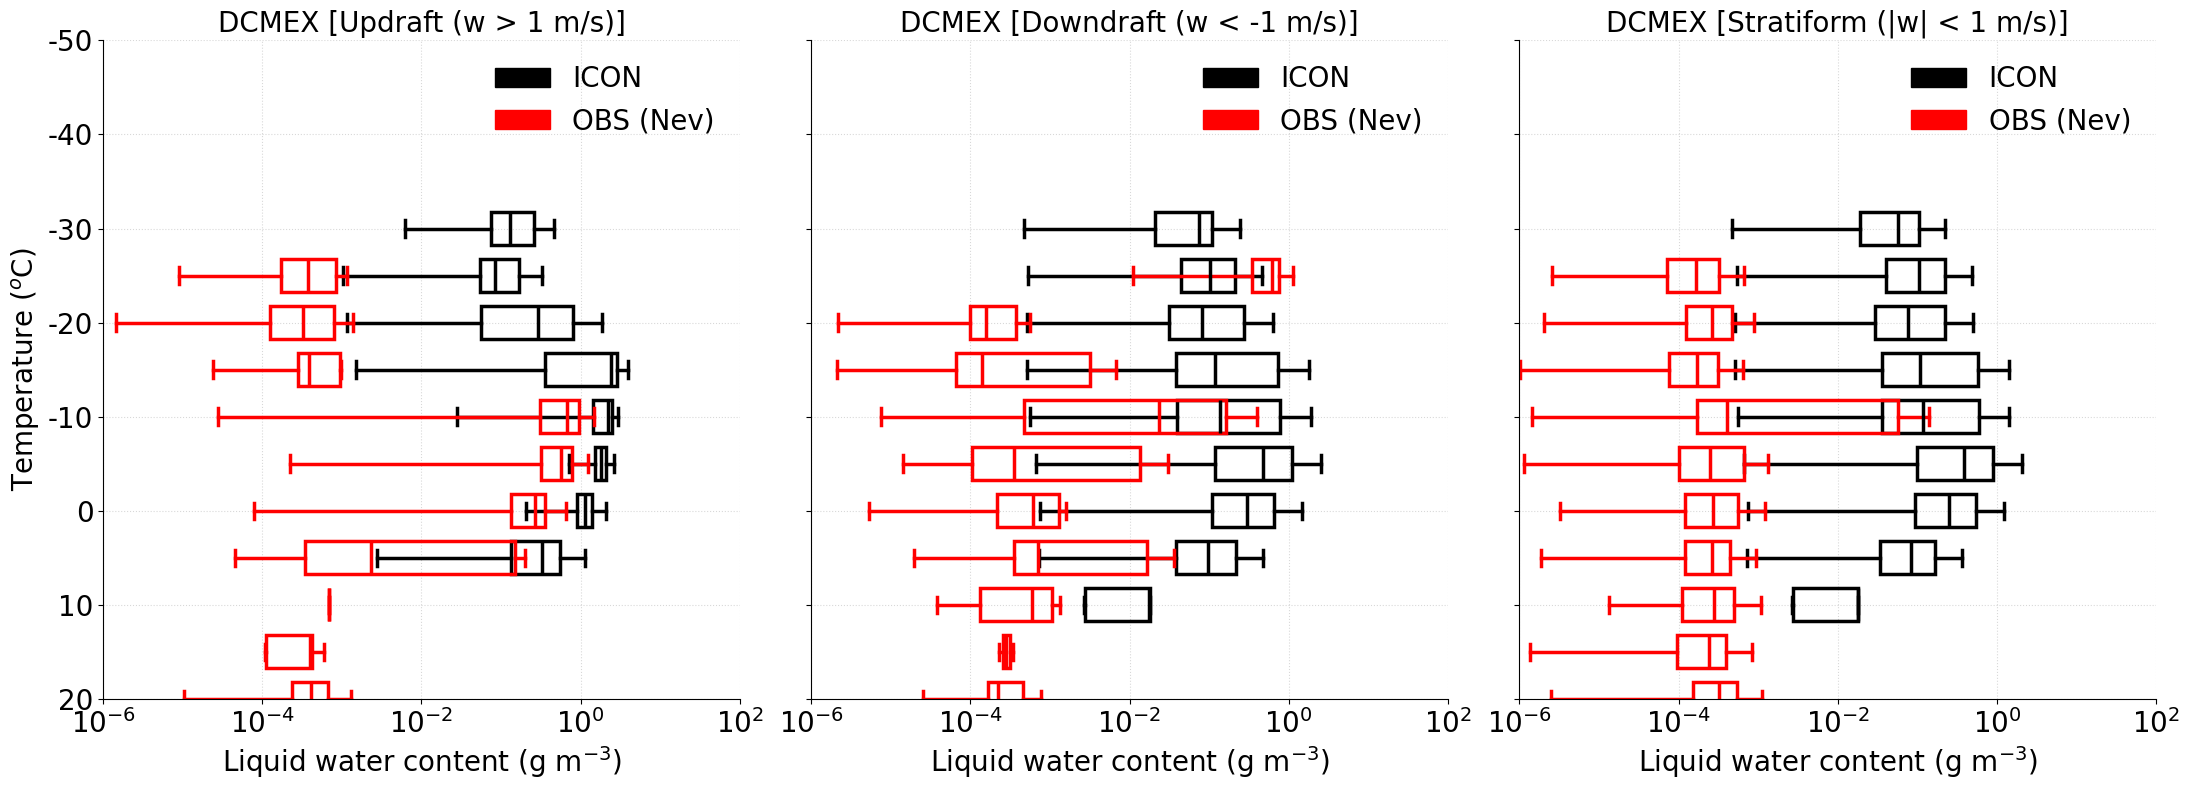

In [145]:


fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(lwc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='black', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_nev_up_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(lwc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='black', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_nev_dn_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 2:
        #ax.plot(lwc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(lwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='black', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(lwc_nev_st_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-6, 1.e2)
    ax.set_xticklabels([1.e-6, 1.e-4, 1.e-2, 1.e0, 1.e2], fontsize=fontsize)
    ax.set_ylim(20, -50)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (Nev)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)
#axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
#axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2642268/361349197.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_2642268/361349197.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_2642268/361349197.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)


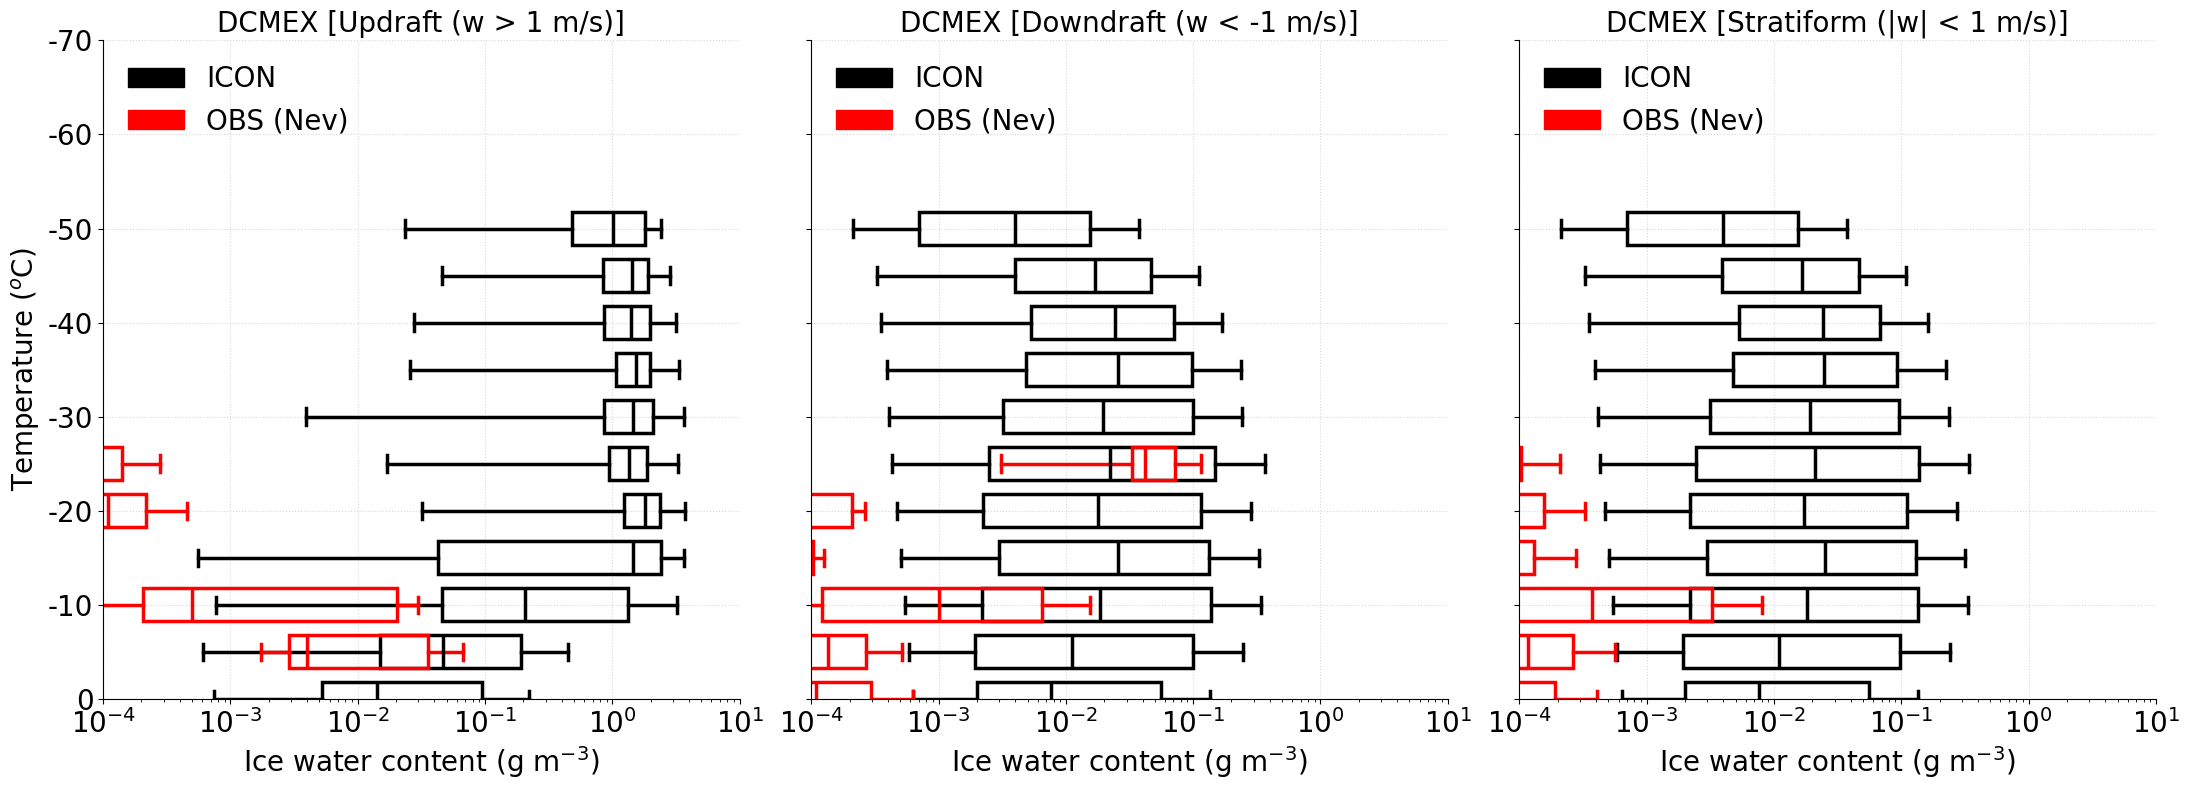

In [146]:


fontsize = 20;
linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(tiwc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='black', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(iwc_nev_up_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(tiwc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='black', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(iwc_nev_dn_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 2:
        #ax.plot(tiwc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(iwc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),  
                   medianprops=dict(color='black', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),  
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(iwc_nev_st_by_bin, positions=temp_nev_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e1)
    ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(0, -70)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=alpha)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    
    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (Nev)')
    
    #obs_patch = mpatches.Patch(color='lightgrey', label='OBS (CIP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -10, -20, -30, -40, -50, -60, -70])
axes[0].set_yticklabels(['0', '-10', '-20', '-30', '-40', '-50', '-60', '-70'], fontsize=fontsize)
#axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
#axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


In [147]:
ds_faam_cdp_phy = data_faam_core_cld_phy

ds_faam_cdp_phy['CDP_TSPM'] = ds_faam_cdp_phy['CDP_TSPM'].dt.floor('s')
ds_faam_cdp_phy['cdnc_percm3'] = ds_faam_cdp_phy['CDP_CONC'].rename({'CDP_TSPM': 'Time'})



ds_faam_cdp_phy['TAT_DI_R'] = data_faam_core_1hz['TAT_DI_R']
ds_faam_cdp_phy['W_C'] = data_faam_core_1hz['W_C']
ds_faam_cdp_phy['tempc'] = data_faam_core_1hz.TAT_DI_R-273.16

filt_cdnc_cdp_up_cond = (ds_faam_cdp_phy.cdnc_percm3 > 1.e-1) & (ds_faam_cdp_phy.W_C > 1.)
filt_cdnc_cdp_dn_cond = (ds_faam_cdp_phy.cdnc_percm3 > 1.e-1) & (ds_faam_cdp_phy.W_C < -1.) & (ds_faam_cdp_phy.W_C > -20.)
filt_cdnc_cdp_st_cond = (ds_faam_cdp_phy.cdnc_percm3 > 1.e-1) & (np.abs(ds_faam_cdp_phy.W_C) < 1.)

# store variables
ds_faam_cdp_phy['cdnc_up_percm3'] = xr.where(filt_cdnc_cdp_up_cond, ds_faam_cdp_phy.cdnc_percm3, np.nan)
ds_faam_cdp_phy['cdnc_dn_percm3'] = xr.where(filt_cdnc_cdp_dn_cond, ds_faam_cdp_phy.cdnc_percm3, np.nan)
ds_faam_cdp_phy['cdnc_st_percm3'] = xr.where(filt_cdnc_cdp_st_cond, ds_faam_cdp_phy.cdnc_percm3, np.nan)

print(ds_faam_cdp_phy.Time)
# Define temperature bins
#temp_cdp_bin = np.array([30., 27., 24., 21., 18., 15., 12., 9., 6., 3., 0., -3., -6., -9., -12., -15., -18., -21., -24., -27., -30.])
temp_cdp_bin = np.arange(-30, 30, 5)
temp_cdp_bin = np.sort(temp_cdp_bin)

tempc_values = ds_faam_cdp_phy['tempc'].values
nan_mask = np.isnan(tempc_values)

valid_tempc_values = tempc_values[~nan_mask]

# which temperature bin each 'ds_cip_new.tempc' value belongs to?
temp_bins_indices = np.digitize(valid_tempc_values, bins=np.append(temp_cdp_bin, np.inf)) - 1
temp_bins_indices = np.clip(temp_bins_indices, 0, len(temp_cdp_bin) - 1)

# assign temp_bin to temp_bin_labels
temp_bin_labels = temp_cdp_bin[temp_bins_indices]
temp_bin_labels_full = np.full_like(tempc_values, np.nan)
temp_bin_labels_full[~nan_mask] = temp_bin_labels

time_coord = ds_faam_cdp_phy['tempc'].coords['Time']
ds_faam_cdp_phy['temp_cdp_bin'] = xr.DataArray(temp_bin_labels_full, coords={'Time': time_coord}, dims=['Time'])

df_up_cdnc_cdp = ds_faam_cdp_phy[['cdnc_up_percm3', 'temp_cdp_bin']].to_dataframe().dropna()
df_dn_cdnc_cdp = ds_faam_cdp_phy[['cdnc_dn_percm3', 'temp_cdp_bin']].to_dataframe().dropna()
df_st_cdnc_cdp = ds_faam_cdp_phy[['cdnc_st_percm3', 'temp_cdp_bin']].to_dataframe().dropna()

df_up_cdnc_cdp = df_up_cdnc_cdp.dropna(subset=['temp_cdp_bin'])
df_dn_cdnc_cdp = df_dn_cdnc_cdp.dropna(subset=['temp_cdp_bin'])
df_st_cdnc_cdp = df_st_cdnc_cdp.dropna(subset=['temp_cdp_bin'])

# Sort the data by bin
cdnc_cdp_up_by_bin = [df_up_cdnc_cdp[df_up_cdnc_cdp['temp_cdp_bin'] == temp]['cdnc_up_percm3'].values for temp in temp_cdp_bin]
cdnc_cdp_dn_by_bin = [df_dn_cdnc_cdp[df_dn_cdnc_cdp['temp_cdp_bin'] == temp]['cdnc_dn_percm3'].values for temp in temp_cdp_bin]
cdnc_cdp_st_by_bin = [df_st_cdnc_cdp[df_st_cdnc_cdp['temp_cdp_bin'] == temp]['cdnc_st_percm3'].values for temp in temp_cdp_bin]

<xarray.DataArray 'Time' (Time: 24313)>
array(['2022-08-02T13:26:01.000000000', '2022-08-02T13:26:02.000000000',
       '2022-08-02T13:26:03.000000000', ..., '2022-08-02T20:11:11.000000000',
       '2022-08-02T20:11:12.000000000', '2022-08-02T20:11:13.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2022-08-02T13:26:01 ... 2022-08-02T20:11:13
    LAT_GIN  (Time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    LON_GIN  (Time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan


/tmp/ipykernel_2642268/1660512837.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_2642268/1660512837.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_2642268/1660512837.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)


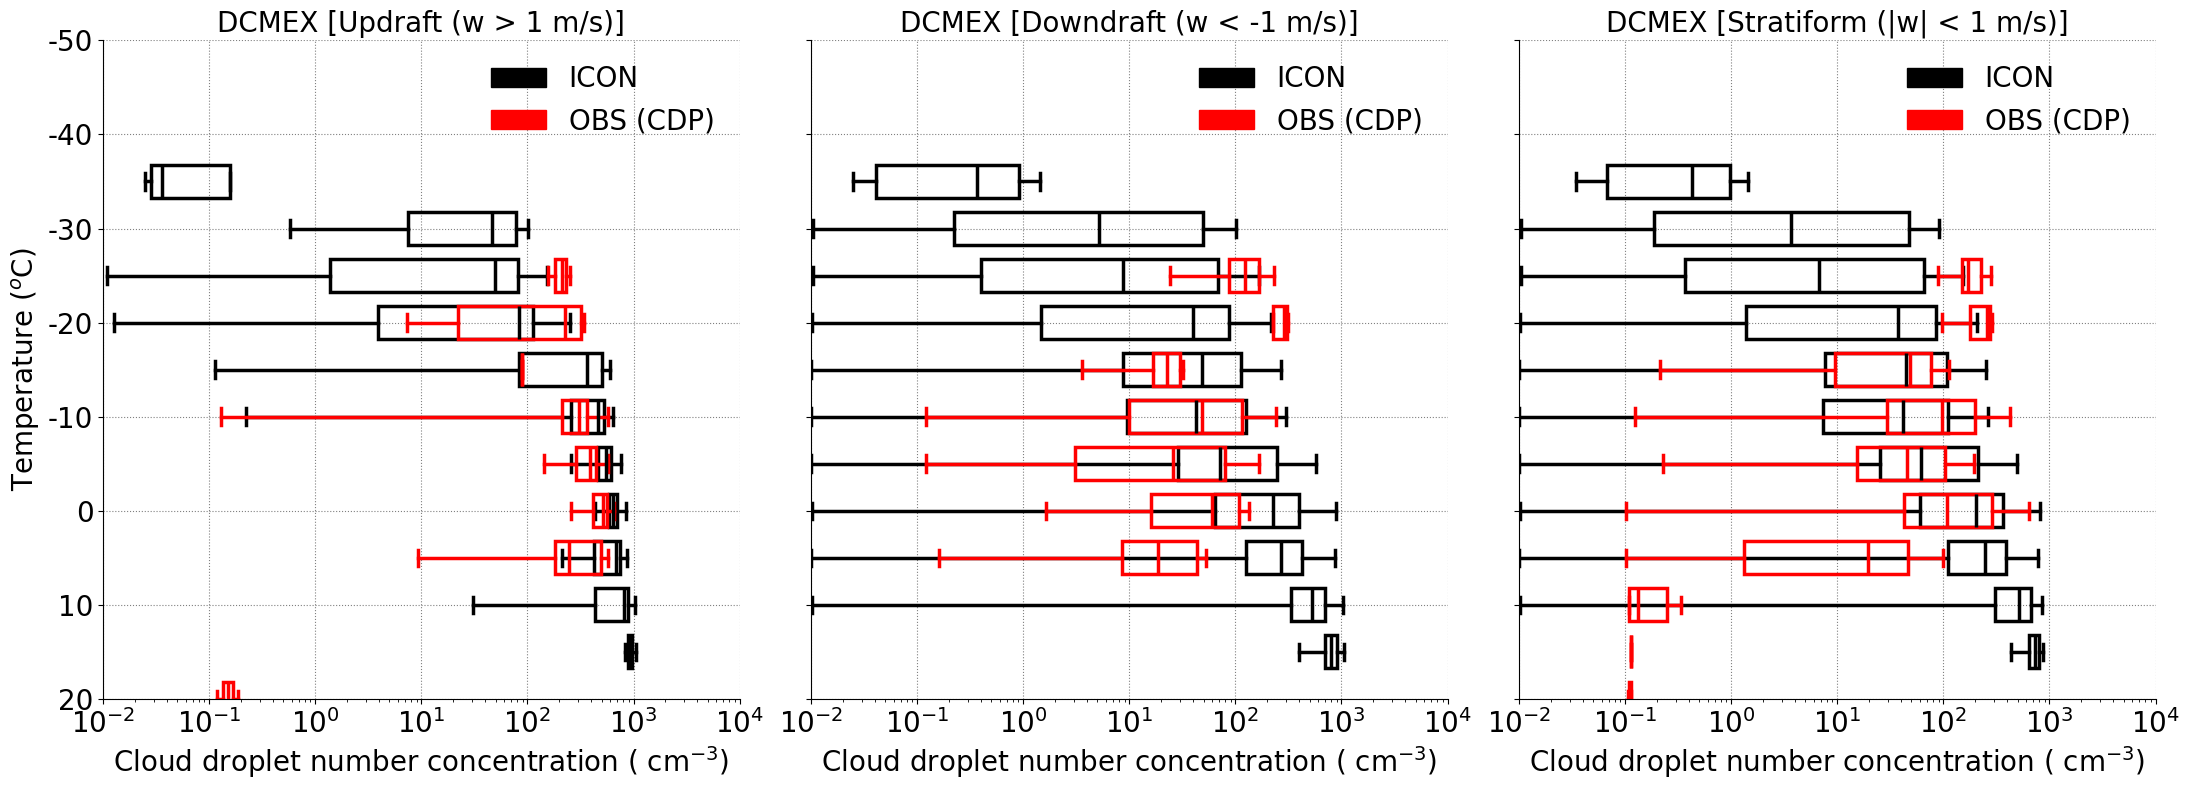

In [148]:


fontsize = 20;
linewidth = 3;
width=2;
alpha=1;

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['DCMEX [Updraft (w > 1 m/s)]', 'DCMEX [Downdraft (w < -1 m/s)]', 'DCMEX [Stratiform (|w| < 1 m/s)]']

linewidth = 2.5;
width=3.5;
alpha1=1;
alpha2=1.;
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(cdnc_up_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_up_by_bin, positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_dn_by_bin, positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 2:
        #ax.plot(cdnc_st_2mom, tempc_2mom, 'k-', linewidth=linewidth+2, label='ICON')
        
        ax.boxplot(cdnc_sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
                   medianprops=dict(color='black', linewidth=linewidth),
                   whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
                   showfliers=False)
        
        ax.boxplot(cdnc_cdp_st_by_bin, positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e4)
    ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
    ax.set_ylim(20, -50)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud droplet number concentration ( cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40, -50])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40', '-50'], fontsize=fontsize)
#axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
#axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()


In [25]:

#######
min_tempc_sip = ds_4sip.tempc.min().values
max_tempc_sip = ds_4sip.tempc.max().values

min_wvel_sip = ds_4sip.w_vel.min().values
max_wvel_sip = ds_4sip.w_vel.max().values

num_temp_bin = 20; num_w_bin = 20;

temp_bin = np.linspace(min_tempc_sip, max_tempc_sip, num_temp_bin+1)
wvel_bin = np.linspace(min_wvel_sip, max_wvel_sip, num_w_bin+1)
#######

#######
tempc_sip_flat = ds_4sip.tempc.values.flatten()
wvel_sip_flat = ds_4sip.w_vel.values.flatten()

qc_sip_flat = ds_4sip.qc.values.flatten()
qi_sip_flat = ds_4sip.qi.values.flatten()
qs_sip_flat = ds_4sip.qs.values.flatten()
qg_sip_flat = ds_4sip.qg.values.flatten()
qh_sip_flat = ds_4sip.qh.values.flatten()
tqi_sip_flat = ds_4sip.tqi.values.flatten()
#######

hist_sip, temp_edges_sip, wvel_edges_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin))

#######
qc_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qc_sip_flat)[0]
qi_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qi_sip_flat)[0]
qs_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qs_sip_flat)[0]
qg_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qg_sip_flat)[0]
qh_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qh_sip_flat)[0]
tqi_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = tqi_sip_flat)[0]
#######

#######
avg_qc_temp_w_sip = qc_sum_sip/hist_sip
avg_qc_temp_w_sip[avg_qc_temp_w_sip < 1.e-9] = np.nan

avg_qi_temp_w_sip = qi_sum_sip/hist_sip
avg_qi_temp_w_sip[avg_qi_temp_w_sip < 1.e-9] = np.nan

avg_qs_temp_w_sip = qs_sum_sip/hist_sip
avg_qs_temp_w_sip[avg_qs_temp_w_sip < 1.e-9] = np.nan

avg_qg_temp_w_sip = qg_sum_sip/hist_sip
avg_qg_temp_w_sip[avg_qg_temp_w_sip < 1.e-9] = np.nan

avg_qh_temp_w_sip = qh_sum_sip/hist_sip
avg_qh_temp_w_sip[avg_qh_temp_w_sip < 1.e-9] = np.nan

avg_tqi_temp_w_sip = tqi_sum_sip/hist_sip
avg_tqi_temp_w_sip[avg_tqi_temp_w_sip < 1.e-9] = np.nan
#######


/tmp/ipykernel_1917976/3900975349.py:8: RuntimeWarning: invalid value encountered in divide
  avg_qc_temp_w_sip = qc_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:11: RuntimeWarning: invalid value encountered in divide
  avg_qi_temp_w_sip = qi_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:14: RuntimeWarning: invalid value encountered in divide
  avg_qs_temp_w_sip = qs_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:17: RuntimeWarning: invalid value encountered in divide
  avg_qg_temp_w_sip = qg_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:20: RuntimeWarning: invalid value encountered in divide
  avg_qh_temp_w_sip = qh_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:23: RuntimeWarning: invalid value encountered in divide
  avg_tqi_temp_w_sip = tqi_sum_sip/hist_sip


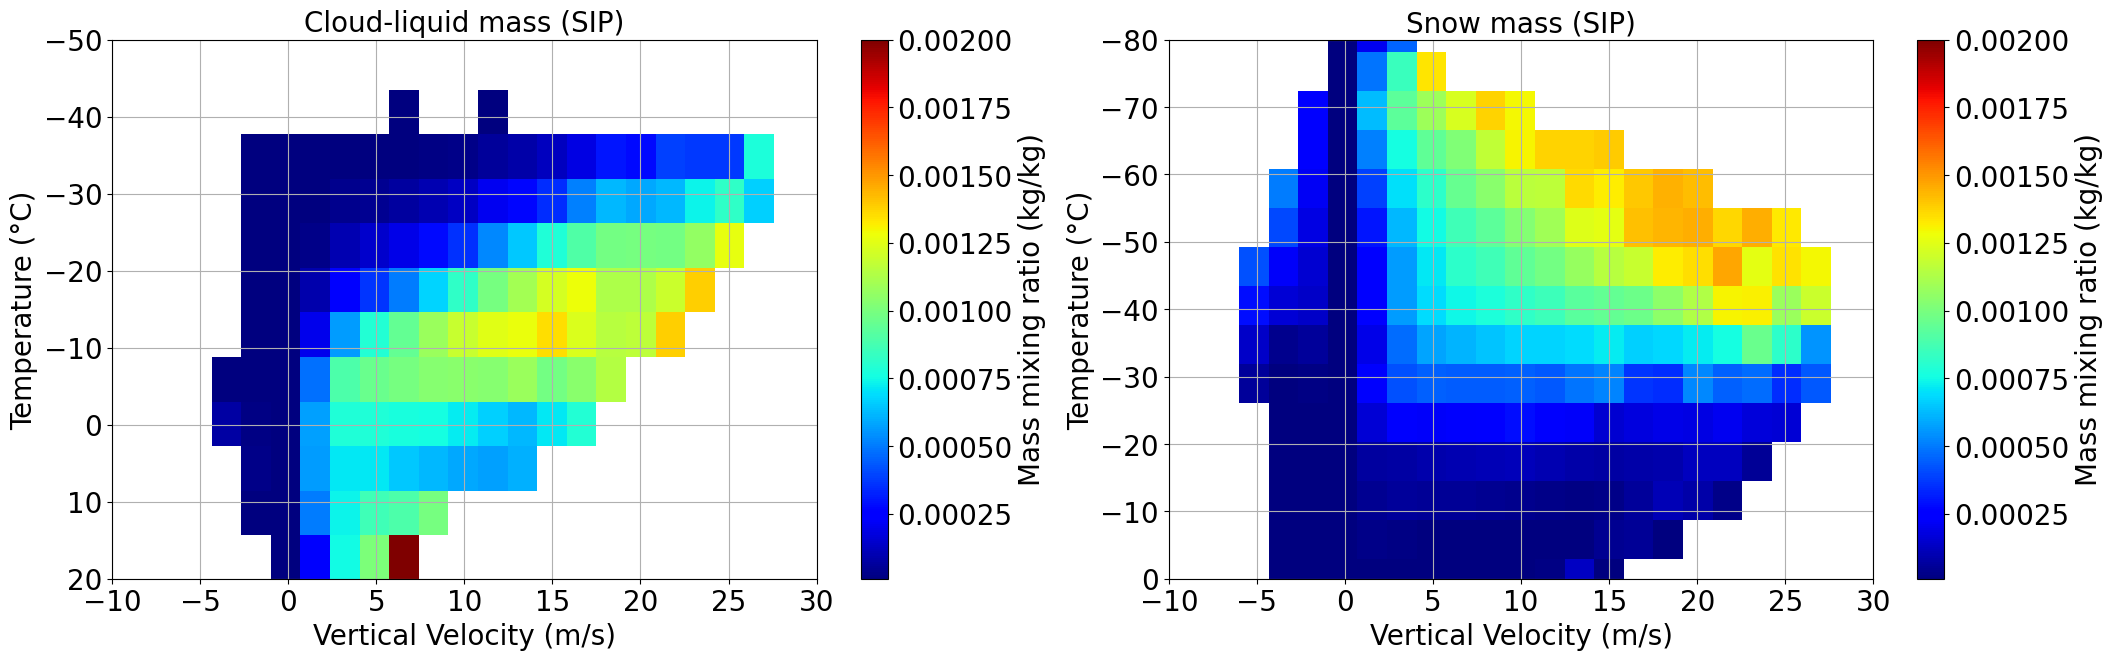

In [37]:

fontsize = 20;

plt.figure(figsize=(25, 7))
plt.subplot(1,2,1)
contour=plt.imshow(avg_qc_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -50)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-liquid mass (SIP)', fontsize=fontsize)

plt.subplot(1,2,2)
contour=plt.imshow(avg_qi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Snow mass (SIP)', fontsize=fontsize)
plt.show()

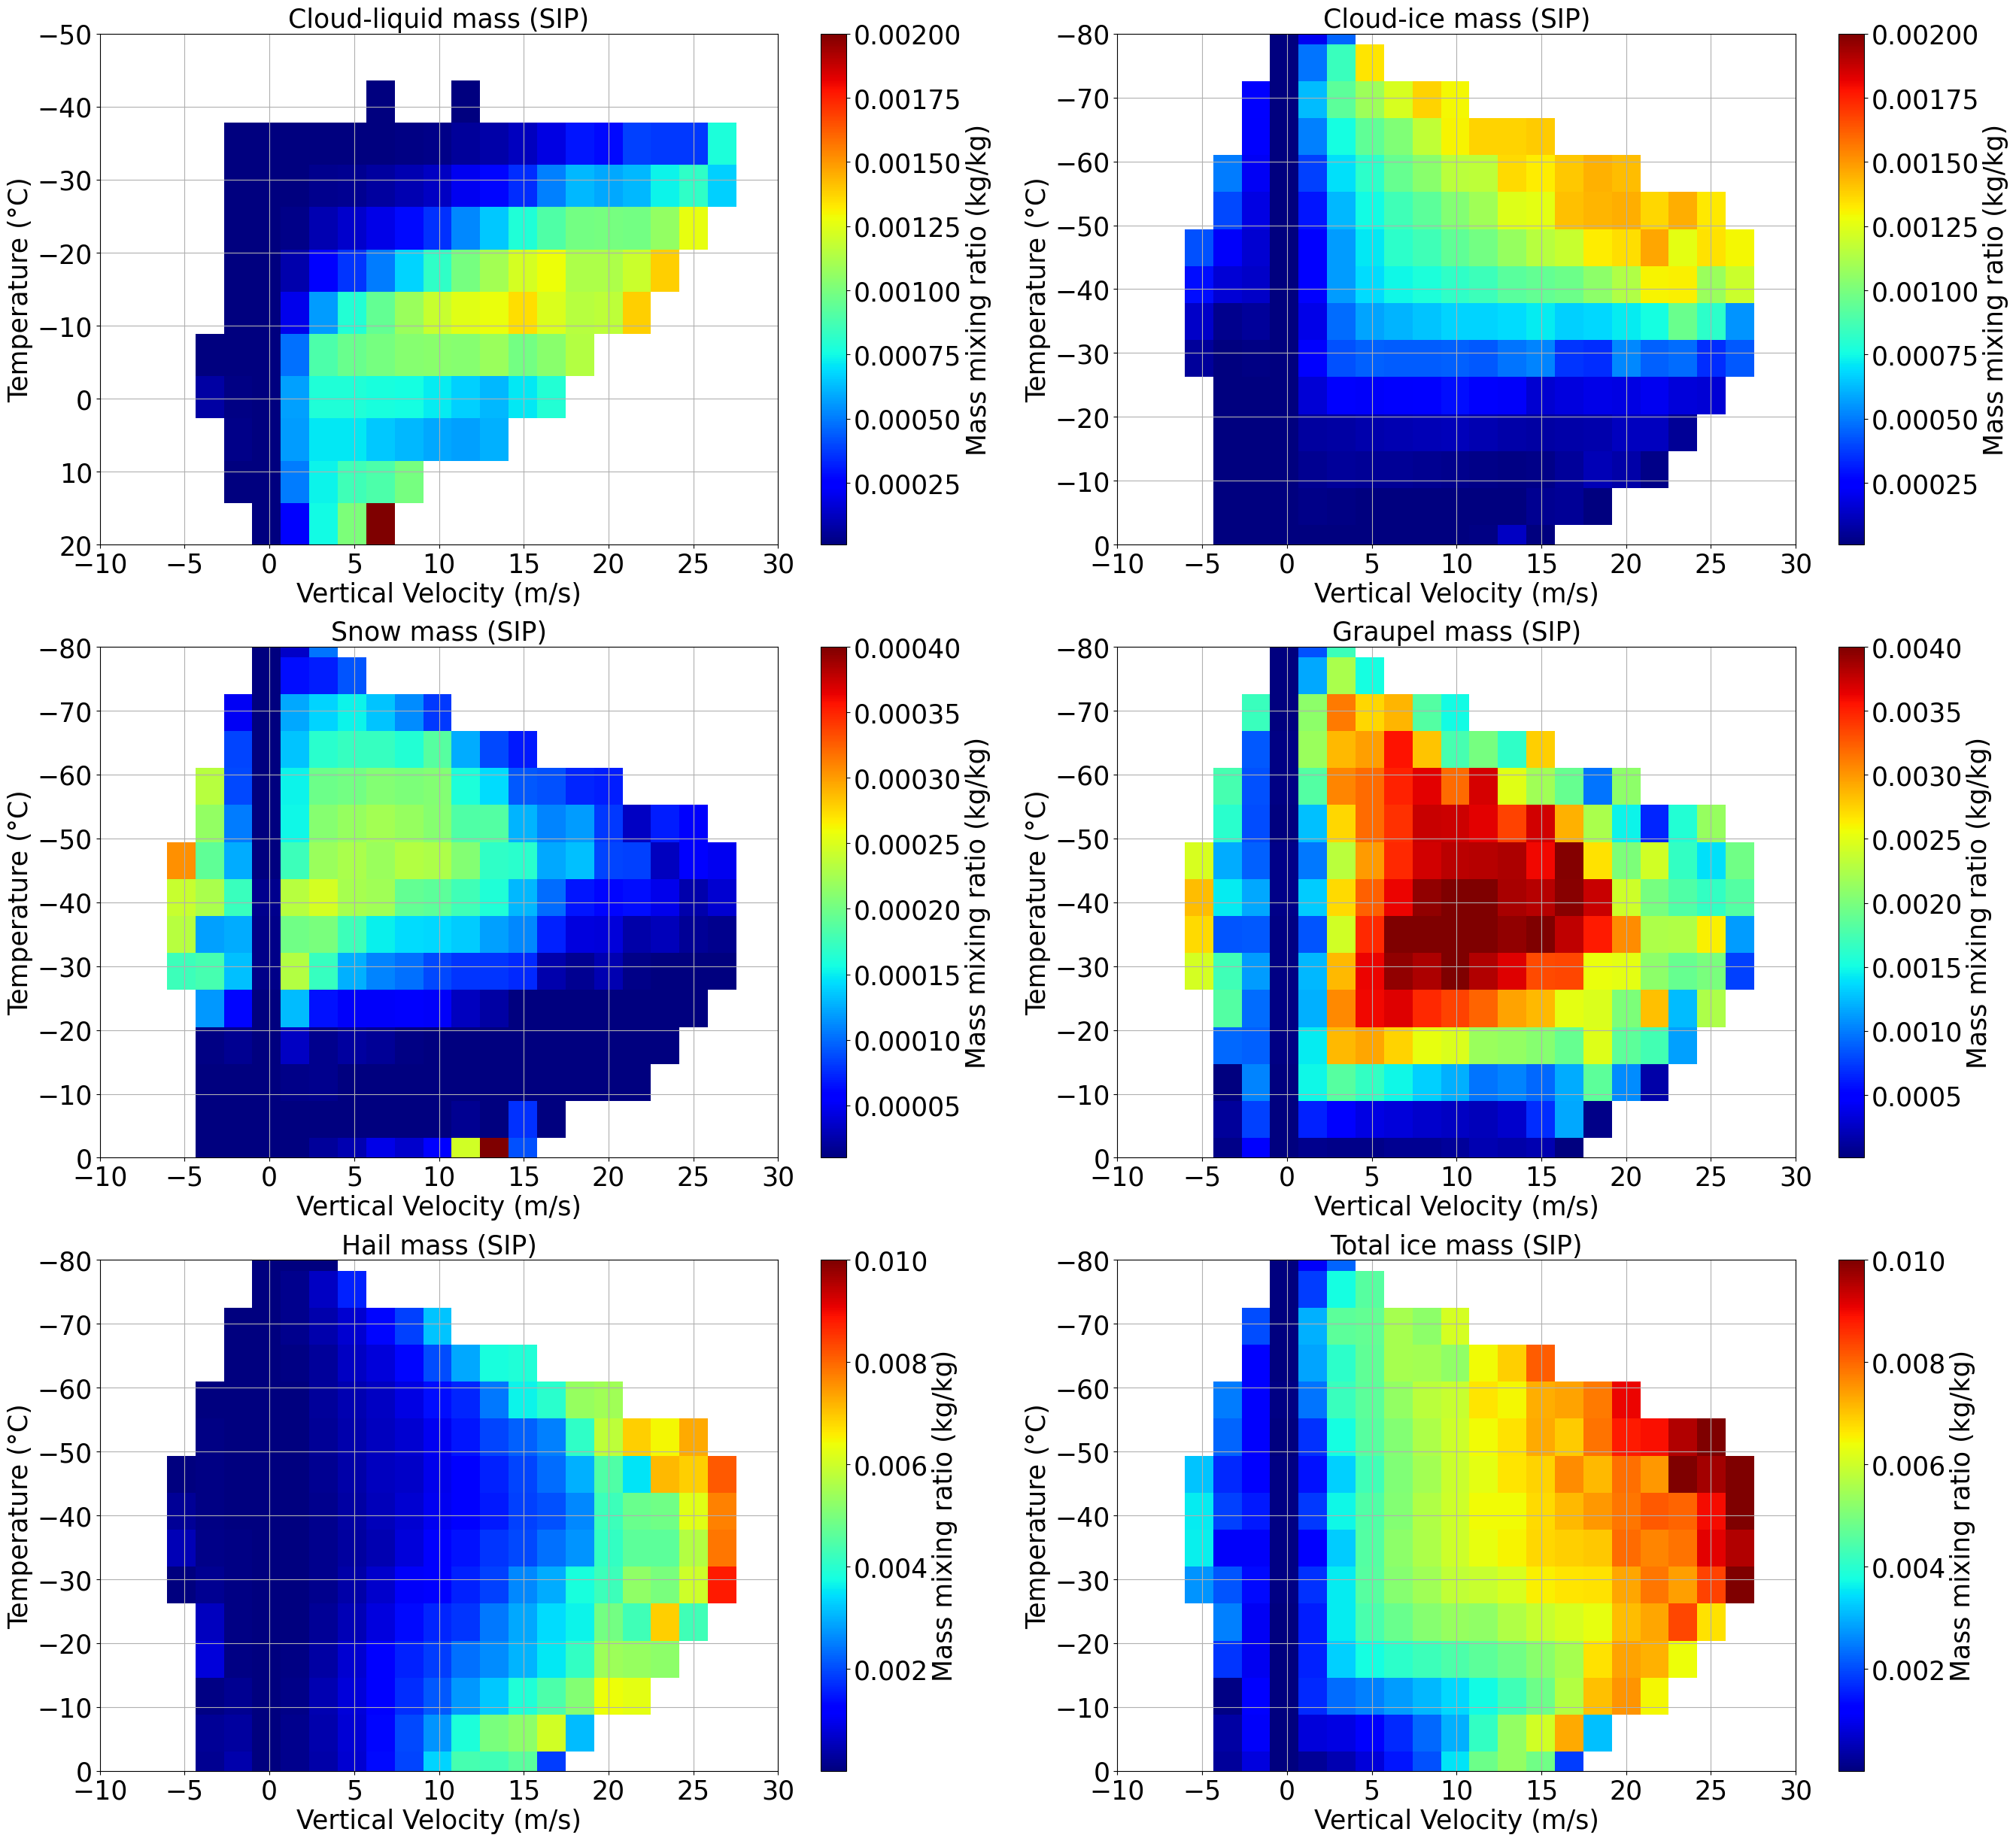

In [64]:


fontsize = 25;

plt.figure(figsize=(32, 30))
plt.subplot(3,2,1)
contour=plt.imshow(avg_qc_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -50)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-liquid mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,2)
contour=plt.imshow(avg_qi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-ice mass (SIP)', fontsize=fontsize)
#plt.show()


#fontsize = 20;

#plt.figure(figsize=(25, 7))
plt.subplot(3,2,3)
contour=plt.imshow(avg_qs_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-4, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Snow mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,4)
contour=plt.imshow(avg_qg_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-3, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Graupel mass (SIP)', fontsize=fontsize)

#plt.show()


#fontsize = 20;

#plt.figure(figsize=(25, 7))
plt.subplot(3,2,5)
contour=plt.imshow(avg_qh_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Hail mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,6)
contour=plt.imshow(avg_tqi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Total ice mass (SIP)', fontsize=fontsize)

plt.show()


In [149]:
ds_4sip.time

<xarray.DataArray 'time' (time: 49)>
array(['2022-08-02T00:00:00.000000000', '2022-08-02T00:30:00.000000000',
       '2022-08-02T01:00:00.000000000', '2022-08-02T01:30:00.000000000',
       '2022-08-02T02:00:00.000000000', '2022-08-02T02:30:00.000000000',
       '2022-08-02T03:00:00.000000000', '2022-08-02T03:30:00.000000000',
       '2022-08-02T04:00:00.000000000', '2022-08-02T04:30:00.000000000',
       '2022-08-02T05:00:00.000000000', '2022-08-02T05:30:00.000000000',
       '2022-08-02T06:00:00.000000000', '2022-08-02T06:30:00.000000000',
       '2022-08-02T07:00:00.000000000', '2022-08-02T07:30:00.000000000',
       '2022-08-02T08:00:00.000000000', '2022-08-02T08:30:00.000000000',
       '2022-08-02T09:00:00.000000000', '2022-08-02T09:30:00.000000000',
       '2022-08-02T10:00:00.000000000', '2022-08-02T10:30:00.000000000',
       '2022-08-02T11:00:00.000000000', '2022-08-02T11:30:00.000000000',
       '2022-08-02T12:00:00.000000000', '2022-08-02T12:30:00.000000000',
       '2022-08-02T13:00:00.000000000', '2022-08-02T13:30:00.000000000',
       '2022-08-02T14:00:00.000000000', '2022-08-02T14:30:00.000000000',
       '2022-08-02T15:00:00.000000000', '2022-08-02T15:30:00.000000000',
       '2022-08-02T16:00:00.000000000', '2022-08-02T16:30:00.000000000',
       '2022-08-02T17:00:00.000000000', '2022-08-02T17:30:00.000000000',
       '2022-08-02T18:00:00.000000000', '2022-08-02T18:30:00.000000000',
       '2022-08-02T19:00:00.000000000', '2022-08-02T19:30:00.000000000',
       '2022-08-02T20:00:00.000000000', '2022-08-02T20:30:00.000000000',
       '2022-08-02T21:00:00.000000000', '2022-08-02T21:30:00.000000000',
       '2022-08-02T22:00:00.000000000', '2022-08-02T22:30:00.000000000',
       '2022-08-02T23:00:00.000000000', '2022-08-02T23:30:00.000000000',
       '2022-08-03T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-08-02 2022-08-02T00:30:00 ... 2022-08-03
Attributes:
    standard_name:  time
    axis:           T

In [11]:

def calc_dewpoint(tempc, rh):
    dewpoint = tempc - ((100. - rh)/5.)
    return dewpoint


def calc_tdew(t, rh):        # Magnus-Tetens approximation
    a = 17.27; b = 237.7;
    alpha = (a*t/(b+t)) + np.log(rh/100)
    td = b*alpha/(a-alpha)
    return td
    
def calc_vir_temp(tc, q):
    #virt_tempk_wk = t/(1. - (ev/p)*(1-0.622))
    temp = tc + (1-0.622*q)
    return temp
    
def calculate_lcl(pressure, temperature, dewpoint):
    l = np.argmin(np.abs(temperature - dewpoint))
    return pressure[l], temperature[l]

def calc_lcl(t, td):
    lcl = td + 125.*(t-td)
    return lcl
    
def e_sat_hpa(tc):
    e_sat_pa = 6.112*np.exp((17.67*tc)/(tc+243.5))
    return e_sat_pa

def calc_parcel_temp(pres, ht, q_sat, tk_lcl):
    grav = 9.8  # acceleration due to gravity [m/s^2]
    eps = 0.622  # ratio of the gas constants for water vapor and dry air
    Rd = 287.  # specific gas constant for dry air [J/(kg*K)]
    cp = 1005.  # specific heat capacity at constant pressure for dry air [J/(kg*K)]
    lv = 2.5e6  # latent heat of vaporization [J/kg]
    Rv = 461.  # specific gas constant for water vapor [J/(kg*K)]

    tk_parcel = np.zeros(len(ht))  
    del_t_par = np.zeros(len(ht))  

    tk_parcel[0] = tk_lcl + 273.15 
    
    for i in range(1, len(ht)):
        dht = ht[i] - ht[i - 1]  
        qs = q_sat[i]  
        term_a = 1. + lv * qs / (Rd * tk_parcel[i - 1])
        term_b = (lv ** 2.) * eps * qs
        term_c = Rd * (tk_parcel[i - 1]) ** 2.
        
        del_t_par[i] = grav * term_a / (cp + (term_b / term_c))

        tk_parcel[i] = tk_parcel[i - 1] - del_t_par[i] * dht
        
    tempc = tk_parcel - 273.15
    return tempc

import numpy as np



def calc_cape(pres, t_env, t_par, tv_env, tv_par):
    """
    Calculate Convective Available Potential Energy (CAPE).
    
    Parameters:
        pres (array): Pressure levels (hPa or Pa).
        t_env (array): Environmental temperature (°C).
        t_par (array): Parcel temperature (°C).
        tv_env (array): Environmental virtual temperature (°C).
        tv_par (array): Parcel virtual temperature (°C).
    
    Returns:
        cape (float): CAPE value (J/kg).
    """
    Rd = 287.0  # gas constant for dry air (J/kg/K)
    
    # Convert temperatures to Kelvin
    tk_env = t_env + 273.15
    tk_v_env = tv_env + 273.15
    tk_par = t_par + 273.15
    tk_v_par = tv_par + 273.15
    
    cape = 0.0
    
    # Loop through pressure levels
    for i in range(1, len(pres)):
        # Check if parcel is warmer than the environment
        if tk_v_par[i] > tk_v_env[i]:
            # Calculate logarithmic pressure difference
            dlnp = np.log(pres[i-1] / pres[i])
            cape = cape + Rd * (tk_v_par[i] - tk_v_env[i]) * dlnp
    return cape
        

In [12]:
ds_4sip.time[26]

<xarray.DataArray 'time' ()>
array('2022-08-02T13:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-08-02T13:00:00
Attributes:
    standard_name:  time
    axis:           T

In [13]:
print(lcl_temp)

NameError: name 'lcl_temp' is not defined

CAPE ::  1021.1269912698493


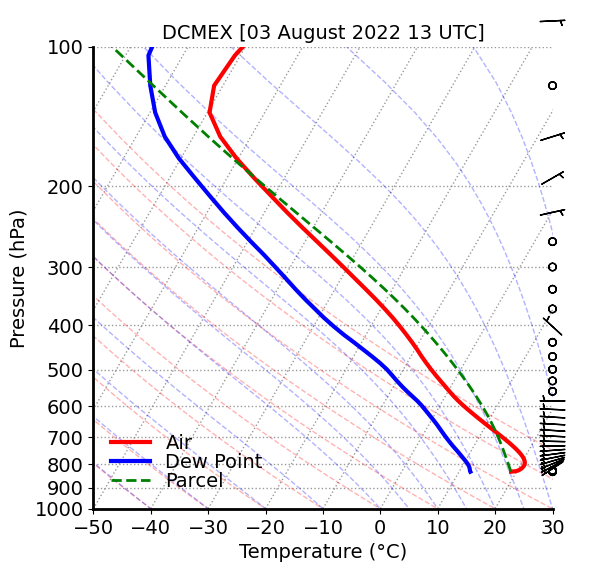

In [14]:

ds_skewt = ds_4sip.sel(time=ds_4sip.time[26])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)
#temp_dew = calc_tdew(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
#lcl_temp = calc_lcl(avg_tempc[0], avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ',parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 6))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
#skew.plot(avg_pres, calc_dewpoint(avg_tempc, avg_rh), 'b-.', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 30)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('DCMEX [03 August 2022 13 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

In [33]:
ds_sonde

<xarray.Dataset>
Dimensions:         (time: 1621, obs: 1)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-02T15:59:46.390014648 ... 2...
    lat             (time) float32 ...
    lon             (time) float32 ...
    gpsalt          (time) float32 ...
Dimensions without coordinates: obs
Data variables: (12/27)
    trajectory      |S1 ...
    launch_time     datetime64[ns] ...
    pres            (time) float32 746.5 746.2 nan 746.3 nan ... nan nan nan nan
    tdry            (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    dp              (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    rh              (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...              ...
    reference_rh    (obs) float32 ...
    reference_wspd  (obs) float32 ...
    reference_wdir  (obs) float32 ...
    reference_lat   (obs) float32 ...
    reference_lon   (obs) float32 ...
    reference_alt   (obs) float32 ...
Attributes: (12/93)
    Conventions:            CF-1.6
    RepoRevision:           V3.4.6
    RepoLastChangedDate:    Fri Apr 30 16:17:27 2021 -0600
    RepoId:                 163b1128fa837a96c93dfe8a59c915ff3185b748
    RepoBranch:             HEAD
    featureType:            trajectory
    ...                     ...
    WindQCDev:              999
    WindQCWL:               30
    WindSats:               6
    WindSmoothWL:           10
    WindVVPresWL:           5
    WindVVdelta:            2.5

CAPE ::  0.0


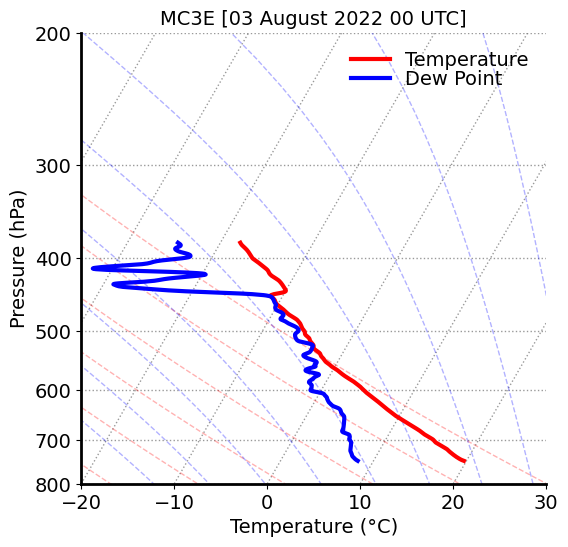

In [57]:

ds_sonde = xr.open_dataset('/work/bb1163/b382718/output/dcmex/observations/aircraft_data/20220802/faam-dropsonde_faam_20220802155302_r0_c310_proc.nc');

pres_sonde = ds_sonde.pres.values
tdry_sonde = ds_sonde.tdry.values
tdew_sonde = ds_sonde.dp.values
rh_sonde   = ds_sonde.rh.values
th_e_sonde = ds_sonde.theta_e.values
th_v_sonde = ds_sonde.theta_v.values
qv_sonde = ds_sonde.mr.values
ht_sonde = ds_sonde.alt.values

valid_indices = ~np.isnan(tdry_sonde) & ~np.isnan(ht_sonde) & ~np.isnan(qv_sonde) & ~np.isnan(rh_sonde) & ~np.isnan(tdew_sonde) & ~np.isnan(pres_sonde)

# Filter the data to remove NaN values
pres_sonde = pres_sonde[valid_indices]
tdry_sonde = tdry_sonde[valid_indices]
tdew_sonde = tdew_sonde[valid_indices]
rh_sonde = rh_sonde[valid_indices]
qv_sonde = qv_sonde[valid_indices]
ht_sonde = ht_sonde[valid_indices]

#qv_sonde = 1.e-3*qv_sonde # g kg-1 to kg kg-1
#----- Calculate parcel properties
e_sat = e_sat_hpa(tdry_sonde)
q_sat = 0.622*e_sat/(pres_sonde-e_sat)
qv_sonde = rh_sonde*q_sat

lcl_pressure, lcl_temp = calculate_lcl(pres_sonde, tdry_sonde, tdew_sonde)
parcel_temp = calc_parcel_temp(pres_sonde, ht_sonde, q_sat, lcl_temp)
Tv_env = calc_vir_temp(tdry_sonde, qv_sonde)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(pres_sonde, tdry_sonde, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ',parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(pres_sonde, tdry_sonde, 'r-', label='Temperature', linewidth=lnwdth)
skew.plot(pres_sonde, tdew_sonde, 'b-', label='Dew Point', linewidth=lnwdth)
#skew.plot(pres_sonde, qv_sonde, 'g-', label='Dew Point', linewidth=lnwdth)
#skew.plot(pres_sonde, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
#if 'u' in ds_skewt and 'v' in ds_skewt:
#    u_wind = avg_u  # Zonal wind component
#    v_wind = avg_v  # Meridional wind component
#    skew.plot_barbs(avg_pres, u_wind, v_wind, length=6, color='black')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-20, 30)
ax.set_ylim(800., 200)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('MC3E [03 August 2022 00 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

In [28]:
print(ds_4sip.time[24])

<xarray.DataArray 'time' ()>
array('2022-08-02T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-08-02T12:00:00
Attributes:
    standard_name:  time
    axis:           T


In [29]:

ds_skewt = ds_4sip.sel(time=ds_4sip.time[24])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)
#temp_dew = calc_tdew(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
#lcl_temp = calc_lcl(avg_tempc[0], avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ',parcel_cape)
#------

CAPE ::  0.0


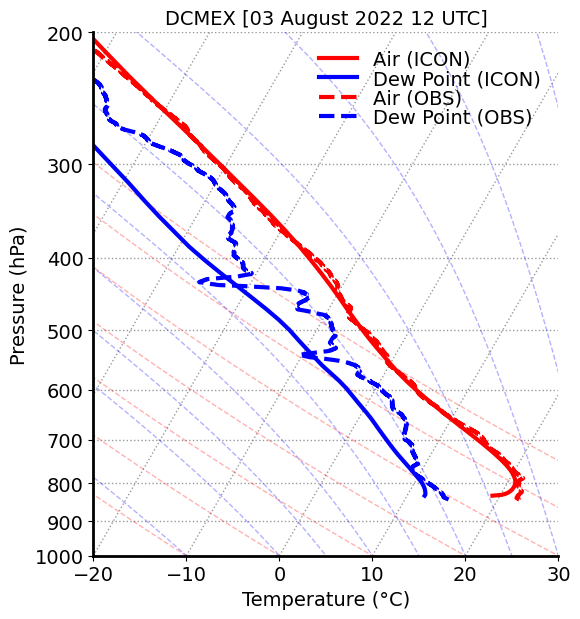

In [32]:

file_path = '/work/bk1415/b382718/output/dcmex/observations/wyoming_sonde/sonde_dcmex_20220802_1200UTC'
column_names = ['pres', 'height', 'temp', 'Tdew', 'relhum', 'qv', 'w_dir', 'w_wind', 'theta', 'theta_e', 'theta_v']


# Specify invalid values (strings or other markers for missing data)
invalid_values = ['-----------------------------------------------------------------------------', '9999.0', '999.0']

# Read the data and replace invalid values with NaN
ds_sonde = pd.read_csv(file_path, sep='\s+', skiprows=6, names=column_names, na_values=invalid_values)

# Now you can drop rows with NaN values if needed
ds_sonde.dropna(inplace=True)


# Read the data with column names
#ds_sonde = pd.read_csv(file_path, sep='\s+', skiprows=5, names=column_names)

#ds_sonde = ds_sonde[(ds_sonde['temp'] != 999.0) & (ds_sonde['pres'] != 9999.0) & 
#           (ds_sonde['Tdew'] != 999.0) & (ds_sonde['relhum'] != 999.0) & (ds_sonde['u_wind'] != 999.0) &
#           (ds_sonde['v_wind'] != 999.0)& (ds_sonde['w_wind'] != 999.0)& (ds_sonde['altitude'] != 99999.0)] 

temp_sonde = ds_sonde.temp.values
pres_sonde = ds_sonde.pres.values
tdew_sonde = ds_sonde.Tdew.values
rh_sonde = ds_sonde.relhum.values
qv_sonde = ds_sonde.qv.values
w_sonde = ds_sonde.w_wind.values
ht_sonde = ds_sonde.height.values


#----- Calculate parcel properties
#e_sat = e_sat_hpa(temp_sonde)
#q_sat = 0.622*e_sat/(pres_sonde-e_sat)
#qv_sonde = rh_sonde*q_sat

#lcl_pressure, lcl_temp = calculate_lcl(pres_sonde, temp_sonde, tdew_sonde)
#parcel_temp = calc_parcel_temp(pres_sonde, ht_sonde, q_sat, lcl_temp)
#Tv_env = calc_vir_temp(tdry_sonde, qv_sonde)
#Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
#parcel_cape = calc_cape(pres_sonde, temp_sonde, parcel_temp, Tv_env, Tv_parcel)
#print('CAPE :: ',parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T

skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point (ICON)', linewidth=lnwdth)

skew.plot(pres_sonde* units.hPa, temp_sonde* units.degC, 'r--', label='Air (OBS)', linewidth=lnwdth)
skew.plot(pres_sonde* units.hPa, tdew_sonde* units.degC, 'b--', label='Dew Point (OBS)', linewidth=lnwdth)
#skew.plot(pres_sonde, qv_sonde, 'g-', label='Dew Point', linewidth=lnwdth)
#skew.plot(pres_sonde, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
#if 'u' in ds_skewt and 'v' in ds_skewt:
#    u_wind = avg_u  # Zonal wind component
#    v_wind = avg_v  # Meridional wind component
#    skew.plot_barbs(avg_pres, u_wind, v_wind, length=6, color='black')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-20, 30)
ax.set_ylim(1000., 200)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('DCMEX [03 August 2022 12 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

In [48]:


ds_sr = xr.open_mfdataset('/work/bk1415/b382718/output/dcmex/observations/radar_sr1/DCMEX/SR1/data/20220802/cfrad.20220802*RHI.nc')



/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [52]:
ds_sr


<xarray.Dataset>
Dimensions:                           (time: 2502, frequency: 1, sweep: 1,
                                       r_calib: 1, range: 1001)
Coordinates:
  * frequency                         (frequency) float32 5.593e+09
  * time                              (time) datetime64[ns] 2022-08-02T19:13:...
  * range                             (range) float32 0.0 150.0 ... 1.5e+05
Dimensions without coordinates: sweep, r_calib
Data variables: (12/135)
    volume_number                     (time) float64 4.0 4.0 4.0 ... 17.0 17.0
    platform_type                     (time) |S32 b'fixed' b'fixed' ... b'fixed'
    primary_axis                      (time) |S32 b'axis_z' ... b'axis_z'
    status_xml                        (time) |S1 b'' b'' b'' b'' ... b'' b'' b''
    instrument_type                   (time) |S32 b'radar' b'radar' ... b'radar'
    radar_antenna_gain_h              (time) float64 nan nan nan ... nan nan nan
    ...                                ...
    ZDR                               (time, range) float32 dask.array<chunksize=(40, 1001), meta=np.ndarray>
    KDP                               (time, range) float32 dask.array<chunksize=(40, 1001), meta=np.ndarray>
    PHIDP                             (time, range) float32 dask.array<chunksize=(40, 1001), meta=np.ndarray>
    SQI                               (time, range) float32 dask.array<chunksize=(40, 1001), meta=np.ndarray>
    RHOHV                             (time, range) float32 dask.array<chunksize=(40, 1001), meta=np.ndarray>
    DBZV                              (time, range) float32 dask.array<chunksize=(40, 1001), meta=np.ndarray>
Attributes: (12/25)
    Conventions:          CF-1.7
    Sub_conventions:      CF-Radial instrument_parameters radar_parameters ra...
    version:              CF-Radial-1.4
    title:                RHI_DCM
    institution:          
    references:           Conversi
    ...                   ...
    site_name:            SR1
    scan_name:            
    scan_id:              0
    platform_is_mobile:   false
    n_gates_vary:         false
    ray_times_increase:   true

In [45]:
print(ds_sr.pressure_altitude_correction.max().values)

0.0


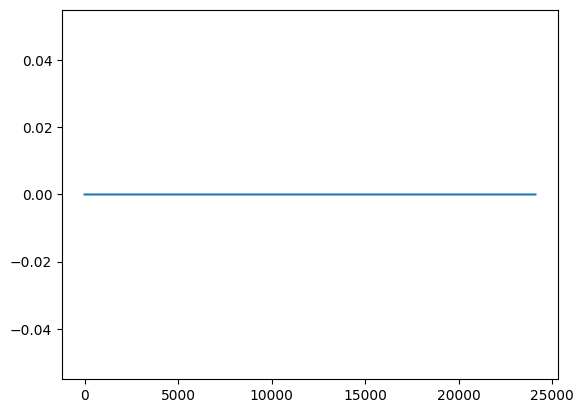

In [43]:
plt.plot(ds_sr.pressure_altitude_correction)

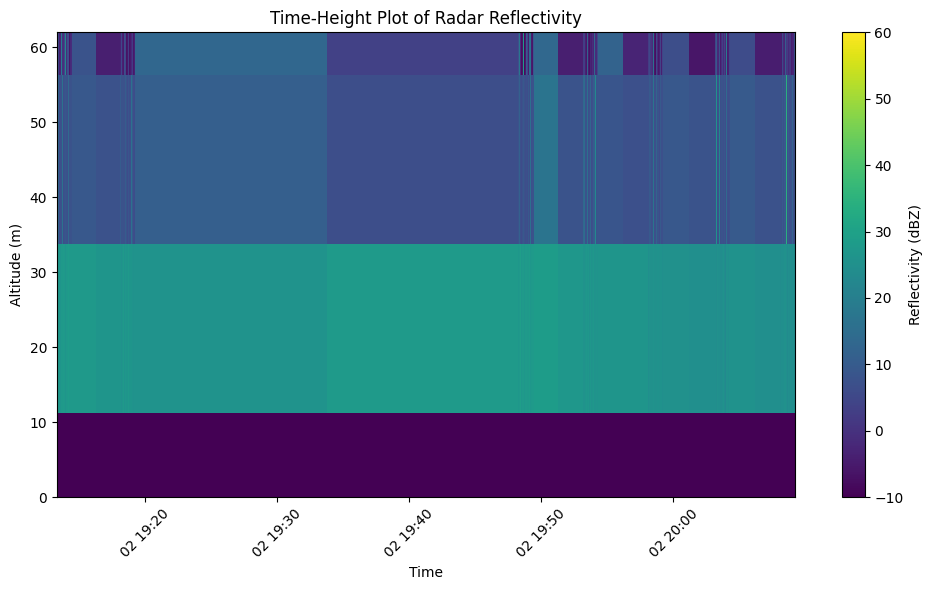

In [53]:


time = ds_sr['time']
altitude = 1.e-3*150.*ds_sr['range'] # range resolution for SMART (SR1) radar is 150 m Finney et al. (2024, Table 2)
dbz = ds_sr['DBZV']
lon = ds_sr['longitude']
lat = ds_sr['latitude']


# Create the plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(time, altitude, dbz.T, shading='auto', cmap='viridis', vmin=-10, vmax=60)

# Add colorbar
cbar = plt.colorbar(label='Reflectivity (dBZ)')

plt.ylim(0, 62.)
# Labels and title
plt.xlabel('Time')
plt.ylabel('Altitude (m)')
plt.title('Time-Height Plot of Radar Reflectivity')

# Format x-axis for better time representation
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:


mean_ht_nosip = ds_nosip.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

mean_ht_4sip = ds_4sip.z_mc.mean(dim=('time','ncells'))
mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_ht_norf = ds_norf.z_mc.mean(dim=('time','ncells'))
mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

mean_ht_nohm = ds_nohm.z_mc.mean(dim=('time','ncells'))
mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

mean_ht_nobr = ds_nobr.z_mc.mean(dim=('time','ncells'))
mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

mean_ht_nosb = ds_nosb.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

w_thres = 2.
# Latent heating rate with No SIP
filt_lhr = xr.where((ds_nosip.tq > 1.e-6) & (ds_nosip.w_vel > w_thres), ds_nosip.d_lhr, np.nan)
lhr_kpers_nosip = (1./1800.) * np.gradient(ds_nosip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosip = lhr_kpers_nosip * 86400.
mean_lhr_kperd_nosip = np.mean(lhr_kperd_nosip, axis=(0,2))

# Latent heating rate with 4-SIP
filt_lhr = xr.where((ds_4sip.tq > 1.e-6) & (ds_4sip.w_vel > w_thres), ds_4sip.d_lhr, np.nan)
lhr_kpers_4sip = (1./1800.) * np.gradient(ds_4sip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_4sip = lhr_kpers_4sip * 86400.
mean_lhr_kperd_4sip = np.mean(lhr_kperd_4sip, axis=(0,2))

# Latent heating rate with No Raindrop Shattering (RF)
filt_lhr = xr.where((ds_norf.tq > 1.e-6) & (ds_norf.w_vel > w_thres), ds_norf.d_lhr, np.nan)
lhr_kpers_norf = (1./1800.) * np.gradient(ds_norf.d_lhr, axis=0) # w.r.t. time
lhr_kperd_norf = lhr_kpers_norf * 86400.
mean_lhr_kperd_norf = np.mean(lhr_kperd_norf, axis=(0,2))

# Latent heating rate with No Hallett-Mossop (HM)
filt_lhr = xr.where((ds_nohm.tq > 1.e-6) & (ds_nohm.w_vel > w_thres), ds_nohm.d_lhr, np.nan)
lhr_kpers_nohm = (1./1800.) * np.gradient(ds_nohm.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nohm = lhr_kpers_nohm * 86400.
mean_lhr_kperd_nohm = np.mean(lhr_kperd_nohm, axis=(0,2))

# Latent heating rate with No ice-ice collision breakup (BR)
filt_lhr = xr.where((ds_nobr.tq > 1.e-6) & (ds_nobr.w_vel > w_thres), ds_nobr.d_lhr, np.nan)
lhr_kpers_nobr = (1./1800.) * np.gradient(ds_nobr.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nobr = lhr_kpers_nobr * 86400.
mean_lhr_kperd_nobr = np.mean(lhr_kperd_nobr, axis=(0,2))

# Latent heating rate with No Sublimation (SB)
filt_lhr = xr.where((ds_nosb.tq > 1.e-6) & (ds_nosb.w_vel > w_thres), ds_nosb.d_lhr, np.nan)
lhr_kpers_nosb = (1./1800.) * np.gradient(ds_nosb.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosb = lhr_kpers_nosb * 86400.
mean_lhr_kperd_nosb = np.mean(lhr_kperd_nosb, axis=(0,2))


# Change in lhr w.r.t. control
del_lhr_kperd_norf = mean_lhr_kperd_4sip-mean_lhr_kperd_norf
del_lhr_kperd_nohm = mean_lhr_kperd_4sip-mean_lhr_kperd_nohm
del_lhr_kperd_nobr = mean_lhr_kperd_4sip-mean_lhr_kperd_nobr
del_lhr_kperd_nosb = mean_lhr_kperd_4sip-mean_lhr_kperd_nosb
del_lhr_kperd_nosip = mean_lhr_kperd_4sip-mean_lhr_kperd_nosip


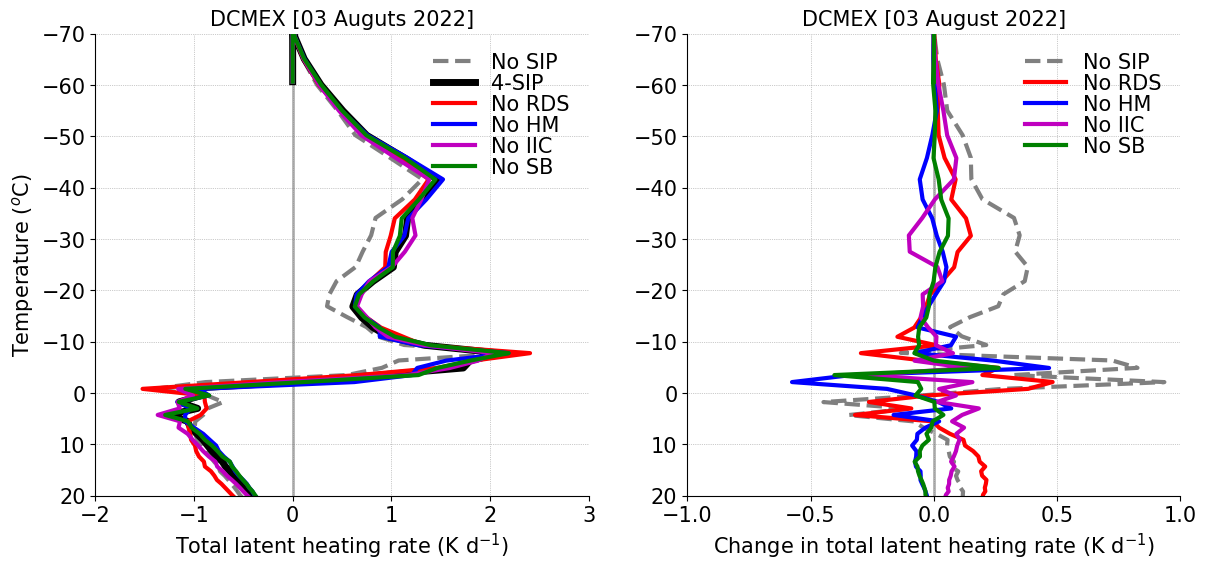

In [10]:


fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(mean_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(mean_lhr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(mean_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(mean_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-2, 3)
plt.ylim(20, -70)
plt.xticks([-2, -1, 0, 1, 2, 3], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 Auguts 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)

plt.subplot(1,2,2)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(del_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-1, 1)
plt.ylim(20, -70)
plt.xticks([-1, -0.5, 0, 0.5, 1], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


In [7]:


mean_ht_nosip = ds_nosip.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

mean_ht_4sip = ds_4sip.z_mc.mean(dim=('time','ncells'))
mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_ht_norf = ds_norf.z_mc.mean(dim=('time','ncells'))
mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

mean_ht_nohm = ds_nohm.z_mc.mean(dim=('time','ncells'))
mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

mean_ht_nobr = ds_nobr.z_mc.mean(dim=('time','ncells'))
mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

mean_ht_nosb = ds_nosb.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

w_thres = 2.
# LW/SW heating rate with No SIP
mean_lwr_kperd_nosip = 86400.*ds_nosip.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nosip = 86400.*ds_nosip.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nosip = mean_lwr_kperd_nosip + mean_swr_kperd_nosip

# LW/SW heating rate with No SIP
mean_lwr_kperd_4sip = 86400.*ds_4sip.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_4sip = 86400.*ds_4sip.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_4sip = mean_lwr_kperd_4sip + mean_swr_kperd_4sip

# LW/SW heating rate with No SIP
mean_lwr_kperd_norf = 86400.*ds_norf.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_norf = 86400.*ds_norf.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_norf = mean_lwr_kperd_norf + mean_swr_kperd_norf

# LW/SW heating rate with No SIP
mean_lwr_kperd_nohm = 86400.*ds_nohm.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nohm = 86400.*ds_nohm.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nohm = mean_lwr_kperd_nohm + mean_swr_kperd_nohm

# LW/SW heating rate with No SIP
mean_lwr_kperd_nobr = 86400.*ds_nobr.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nobr = 86400.*ds_nobr.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nobr = mean_lwr_kperd_nobr + mean_swr_kperd_nobr

# LW/SW heating rate with No SIP
mean_lwr_kperd_nosb = 86400.*ds_nosb.ddt_temp_radlw.mean(dim=('time','ncells'))
mean_swr_kperd_nosb = 86400.*ds_nosb.ddt_temp_radsw.mean(dim=('time','ncells'))
mean_tot_rad_kperd_nosb = mean_lwr_kperd_nosb + mean_swr_kperd_nosb

# Change in tot rad. heating w.r.t. control
del_tot_rad_kperd_norf = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_norf
del_tot_rad_kperd_nohm = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nohm
del_tot_rad_kperd_nobr = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nobr
del_tot_rad_kperd_nosb = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nosb
del_tot_rad_kperd_nosip = mean_tot_rad_kperd_4sip-mean_tot_rad_kperd_nosip

# Change in LW rad. heating w.r.t. control
del_lwr_kperd_norf = mean_lwr_kperd_4sip-mean_lwr_kperd_norf
del_lwr_kperd_nohm = mean_lwr_kperd_4sip-mean_lwr_kperd_nohm
del_lwr_kperd_nobr = mean_lwr_kperd_4sip-mean_lwr_kperd_nobr
del_lwr_kperd_nosb = mean_lwr_kperd_4sip-mean_lwr_kperd_nosb
del_lwr_kperd_nosip = mean_lwr_kperd_4sip-mean_lwr_kperd_nosip

# Change in SW rad. heating w.r.t. control
del_swr_kperd_norf = mean_swr_kperd_4sip-mean_swr_kperd_norf
del_swr_kperd_nohm = mean_swr_kperd_4sip-mean_swr_kperd_nohm
del_swr_kperd_nobr = mean_swr_kperd_4sip-mean_swr_kperd_nobr
del_swr_kperd_nosb = mean_swr_kperd_4sip-mean_swr_kperd_nosb
del_swr_kperd_nosip = mean_swr_kperd_4sip-mean_swr_kperd_nosip


(20.0, -60.0)

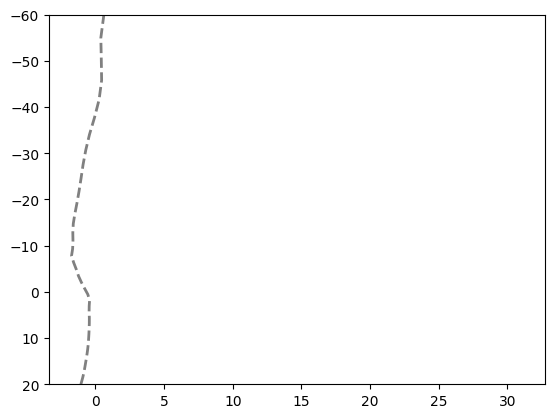

In [9]:
plt.plot(mean_tot_rad_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=2, label='No SIP')
plt.ylim(20,-60)

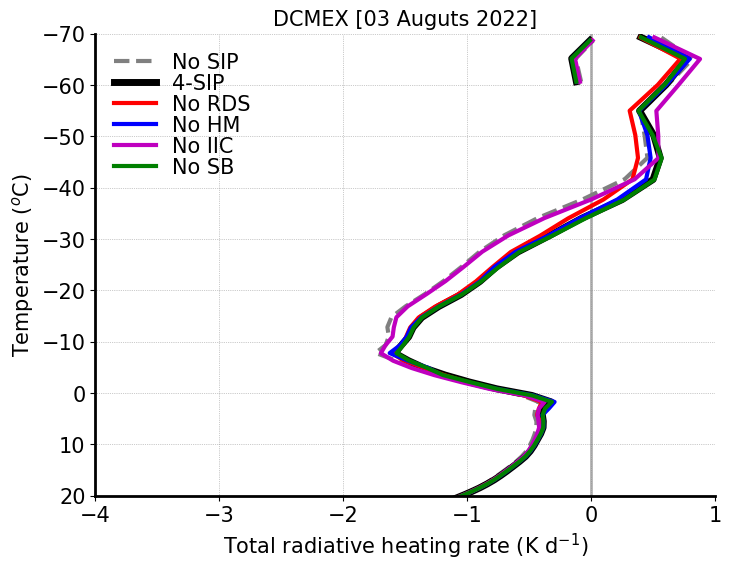

In [10]:
fontsize=15;
lnwdth=3;
alpha=0.6;

mean_tot_rad_kperd_nosip = mean_tot_rad_kperd_nosip.where(mean_tempc_nosip > -70)
mean_tot_rad_kperd_4sip = mean_tot_rad_kperd_4sip.where(mean_tempc_4sip > -70)
mean_tot_rad_kperd_norf = mean_tot_rad_kperd_norf.where(mean_tempc_norf > -70)
mean_tot_rad_kperd_nohm = mean_tot_rad_kperd_nohm.where(mean_tempc_nohm > -70)
mean_tot_rad_kperd_nobr = mean_tot_rad_kperd_nobr.where(mean_tempc_nobr > -70)
mean_tot_rad_kperd_nosb = mean_tot_rad_kperd_nosb.where(mean_tempc_nosb > -70)

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(mean_tot_rad_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(mean_tot_rad_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(mean_tot_rad_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(mean_tot_rad_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_tot_rad_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_tot_rad_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-4, 1)
plt.ylim(20, -70)
plt.xticks([-4, -3, -2, -1, 0, 1], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Total radiative heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 Auguts 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


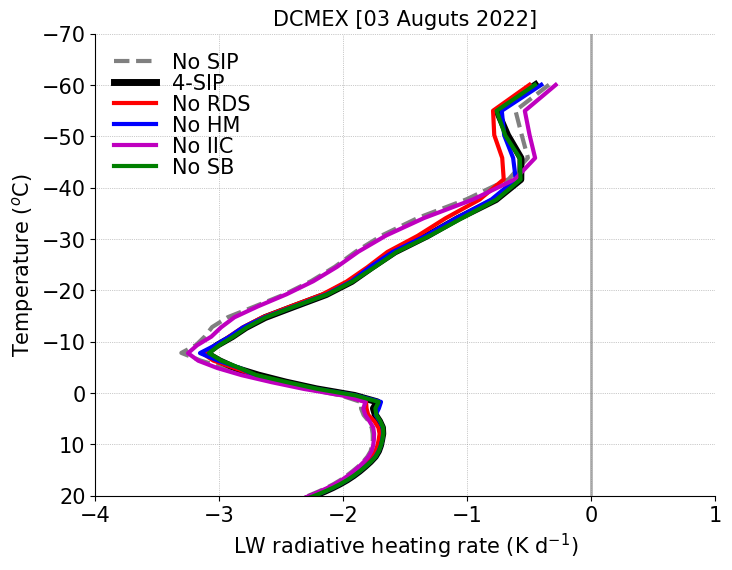

In [25]:
fontsize=15;
lnwdth=3;
alpha=0.6;

mean_lwr_kperd_nosip = mean_lwr_kperd_nosip.where(mean_tempc_nosip > -70)
mean_lwr_kperd_4sip = mean_lwr_kperd_4sip.where(mean_tempc_4sip > -70)
mean_lwr_kperd_norf = mean_lwr_kperd_norf.where(mean_tempc_norf > -70)
mean_lwr_kperd_nohm = mean_lwr_kperd_nohm.where(mean_tempc_nohm > -70)
mean_lwr_kperd_nobr = mean_lwr_kperd_nobr.where(mean_tempc_nobr > -70)
mean_lwr_kperd_nosb = mean_lwr_kperd_nosb.where(mean_tempc_nosb > -70)

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(mean_lwr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(mean_lwr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(mean_lwr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(mean_lwr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_lwr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_lwr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-4, 1)
plt.ylim(20, -70)
plt.xticks([-4, -3, -2, -1, 0, 1], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('LW radiative heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 Auguts 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


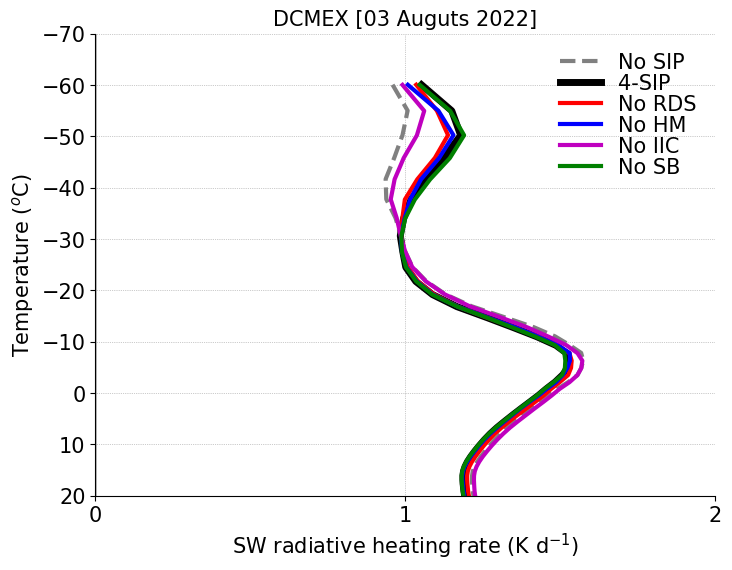

In [28]:
fontsize=15;
lnwdth=3;
alpha=0.6;

mean_swr_kperd_nosip = mean_swr_kperd_nosip.where(mean_tempc_nosip > -70)
mean_swr_kperd_4sip = mean_swr_kperd_4sip.where(mean_tempc_4sip > -70)
mean_swr_kperd_norf = mean_swr_kperd_norf.where(mean_tempc_norf > -70)
mean_swr_kperd_nohm = mean_swr_kperd_nohm.where(mean_tempc_nohm > -70)
mean_swr_kperd_nobr = mean_swr_kperd_nobr.where(mean_tempc_nobr > -70)
mean_swr_kperd_nosb = mean_swr_kperd_nosb.where(mean_tempc_nosb > -70)

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(mean_swr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(mean_swr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(mean_swr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(mean_swr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_swr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_swr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(0, 2)
plt.ylim(20, -70)
plt.xticks([0, 1, 2], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('SW radiative heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 Auguts 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


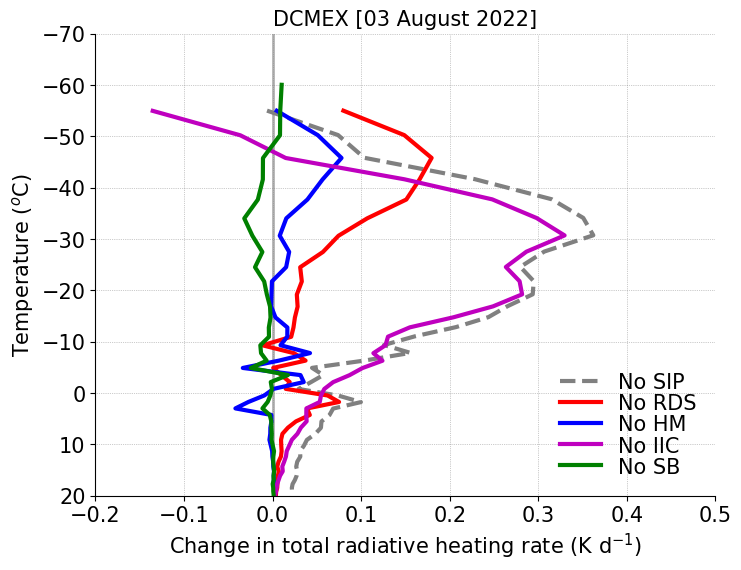

In [9]:


del_tot_rad_kperd_nosip = del_tot_rad_kperd_nosip.where(mean_tempc_nosip > -60)
del_tot_rad_kperd_norf = del_tot_rad_kperd_norf.where(mean_tempc_4sip > -60)
del_tot_rad_kperd_nohm = del_tot_rad_kperd_nohm.where(mean_tempc_norf > -60)
del_tot_rad_kperd_nobr = del_tot_rad_kperd_nobr.where(mean_tempc_nohm > -60)
del_tot_rad_kperd_nosb = del_tot_rad_kperd_nosb.where(mean_tempc_nobr > -60)

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_tot_rad_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_tot_rad_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(del_tot_rad_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_tot_rad_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_tot_rad_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-0.2, 0.5)
plt.ylim(20, -70)
plt.xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in total radiative heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()



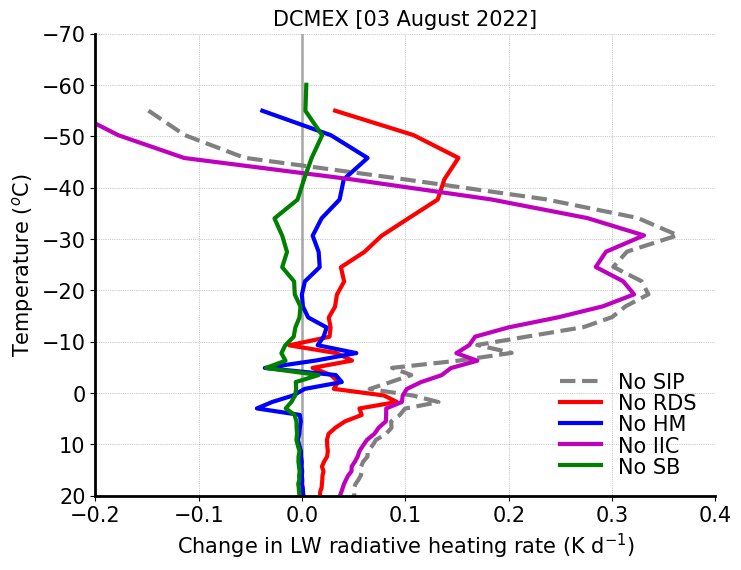

In [12]:


del_lwr_kperd_nosip = del_lwr_kperd_nosip.where(mean_tempc_nosip > -60)
del_lwr_kperd_norf = del_lwr_kperd_norf.where(mean_tempc_4sip > -60)
del_lwr_kperd_nohm = del_lwr_kperd_nohm.where(mean_tempc_norf > -60)
del_lwr_kperd_nobr = del_lwr_kperd_nobr.where(mean_tempc_nohm > -60)
del_lwr_kperd_nosb = del_lwr_kperd_nosb.where(mean_tempc_nobr > -60)

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
#plt.style.use('seaborn-white')

plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_lwr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_lwr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(del_lwr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_lwr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_lwr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-0.2, 0.4)
plt.ylim(20, -70)
plt.xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in LW radiative heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()



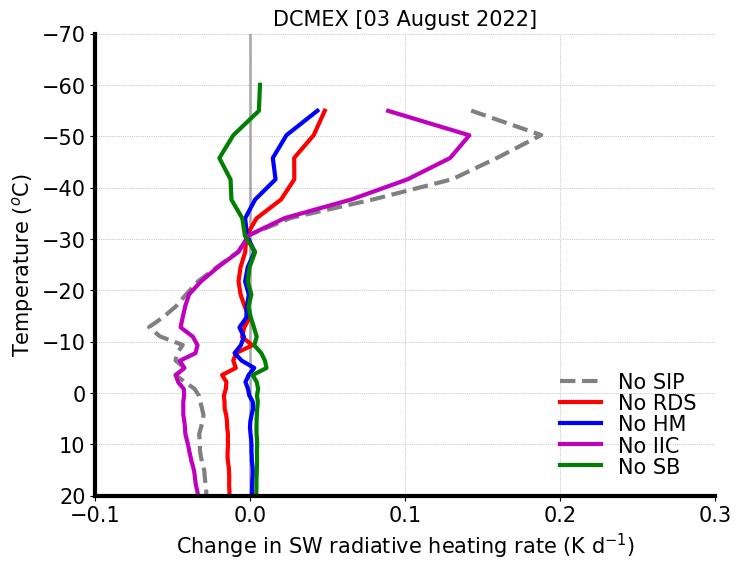

In [11]:


del_swr_kperd_nosip = del_swr_kperd_nosip.where(mean_tempc_nosip > -60)
del_swr_kperd_norf = del_swr_kperd_norf.where(mean_tempc_4sip > -60)
del_swr_kperd_nohm = del_swr_kperd_nohm.where(mean_tempc_norf > -60)
del_swr_kperd_nobr = del_swr_kperd_nobr.where(mean_tempc_nohm > -60)
del_swr_kperd_nosb = del_swr_kperd_nosb.where(mean_tempc_nobr > -60)

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_swr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_swr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(del_swr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_swr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_swr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-0.1, 0.3)
plt.ylim(20, -70)
plt.xticks([-0.1, 0, 0.1, 0.2, 0.3], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in SW radiative heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()



In [14]:


filt_w = xr.where((ds_nosip.omega > 0.) & (ds_nosip.tq > 1.e-9), ds_nosip.omega, np.nan)
mean_omega_dn_nosip = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_4sip.omega > 0.) & (ds_4sip.tq > 1.e-9), ds_4sip.omega, np.nan)
mean_omega_dn_4sip = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_norf.omega > 0.) & (ds_norf.tq > 1.e-9), ds_norf.omega, np.nan)
mean_omega_dn_norf = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nohm.omega > 0.) & (ds_nohm.tq > 1.e-9), ds_nohm.omega, np.nan)
mean_omega_dn_nohm = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nobr.omega > 0.) & (ds_nobr.tq > 1.e-9), ds_nobr.omega, np.nan)
mean_omega_dn_nobr = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nobr.omega > 0.) & (ds_nosb.tq > 1.e-9), ds_nosb.omega, np.nan)
mean_omega_dn_nosb = filt_w.mean(dim=('time','ncells'))


In [15]:

filt_w = xr.where((ds_nosip.omega < 0.) & (ds_nosip.tq > 1.e-9), ds_nosip.omega, np.nan)
mean_omega_up_nosip = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_4sip.omega < 0.) & (ds_4sip.tq > 1.e-9), ds_4sip.omega, np.nan)
mean_omega_up_4sip = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_norf.omega < 0.) & (ds_norf.tq > 1.e-9), ds_norf.omega, np.nan)
mean_omega_up_norf = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nohm.omega < 0.) & (ds_nohm.tq > 1.e-9), ds_nohm.omega, np.nan)
mean_omega_up_nohm = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nobr.omega < 0.) & (ds_nobr.tq > 1.e-9), ds_nobr.omega, np.nan)
mean_omega_up_nobr = filt_w.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nobr.omega < 0.) & (ds_nosb.tq > 1.e-9), ds_nosb.omega, np.nan)
mean_omega_up_nosb = filt_w.mean(dim=('time','ncells'))


In [34]:

filt_w = xr.where((ds_nosip.tq > 1.e-12), ds_nosip.omega, np.nan)
mean_omega_net_nosip = ds_nosip.w_vel.mean(dim=('time','ncells'))

filt_w = xr.where((ds_4sip.tq > 1.e-12), ds_4sip.omega, np.nan)
mean_omega_net_4sip = ds_4sip.w_vel.mean(dim=('time','ncells'))

filt_w = xr.where((ds_norf.tq > 1.e-12), ds_norf.omega, np.nan)
mean_omega_net_norf = ds_norf.w_vel.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nohm.tq > 1.e-12), ds_nohm.omega, np.nan)
mean_omega_net_nohm = ds_nohm.w_vel.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nobr.tq > 1.e-12), ds_nobr.omega, np.nan)
mean_omega_net_nobr = ds_nobr.w_vel.mean(dim=('time','ncells'))

filt_w = xr.where((ds_nosb.tq > 1.e-12), ds_nosb.omega, np.nan)
mean_omega_net_nosb = ds_nosb.w_vel.mean(dim=('time','ncells'))


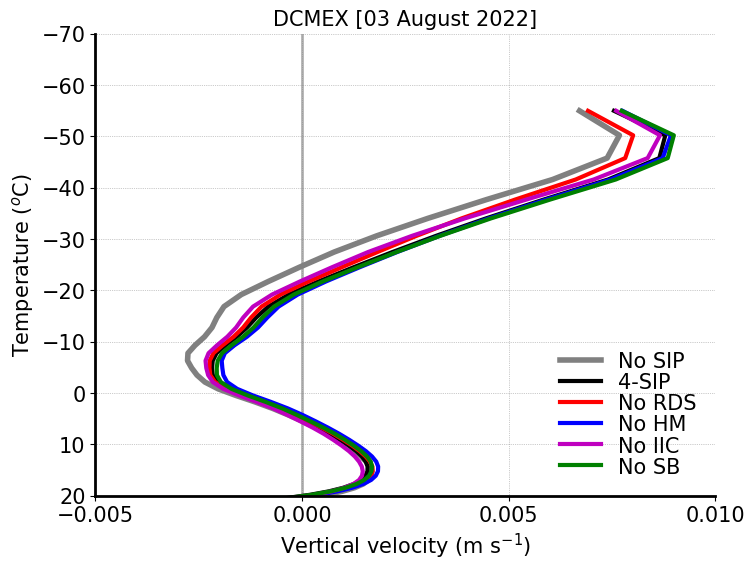

In [12]:

mean_w_up_nosip = ds_nosip.w_vel.where(ds_nosip.w_vel > 0.).mean(dim=('time','ncells'))
mean_w_up_4sip = ds_4sip.w_vel.where(ds_nosip.w_vel > 0.).mean(dim=('time','ncells'))
mean_w_up_norf = ds_norf.w_vel.where(ds_nosip.w_vel > 0.).mean(dim=('time','ncells'))
mean_w_up_nohm = ds_nohm.w_vel.where(ds_nosip.w_vel > 0.).mean(dim=('time','ncells'))
mean_w_up_nobr = ds_nobr.w_vel.where(ds_nosip.w_vel > 0.).mean(dim=('time','ncells'))
mean_w_up_nosb = ds_nosb.w_vel.where(ds_nosip.w_vel > 0.).mean(dim=('time','ncells'))

mean_w_dn_nosip = ds_nosip.w_vel.where(ds_nosip.w_vel < 0.).mean(dim=('time','ncells'))
mean_w_dn_4sip = ds_4sip.w_vel.where(ds_nosip.w_vel < 0.).mean(dim=('time','ncells'))
mean_w_dn_norf = ds_norf.w_vel.where(ds_nosip.w_vel < 0.).mean(dim=('time','ncells'))
mean_w_dn_nohm = ds_nohm.w_vel.where(ds_nosip.w_vel < 0.).mean(dim=('time','ncells'))
mean_w_dn_nobr = ds_nobr.w_vel.where(ds_nosip.w_vel < 0.).mean(dim=('time','ncells'))
mean_w_dn_nosb = ds_nosb.w_vel.where(ds_nosip.w_vel < 0.).mean(dim=('time','ncells'))

mean_w_net_nosip = ds_nosip.w_vel.mean(dim=('time','ncells'))
mean_w_net_4sip = ds_4sip.w_vel.mean(dim=('time','ncells'))
mean_w_net_norf = ds_norf.w_vel.mean(dim=('time','ncells'))
mean_w_net_nohm = ds_nohm.w_vel.mean(dim=('time','ncells'))
mean_w_net_nobr = ds_nobr.w_vel.mean(dim=('time','ncells'))
mean_w_net_nosb = ds_nosb.w_vel.mean(dim=('time','ncells'))

mean_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_w_net_nosip = mean_w_net_nosip.where(mean_tempc > -60)
mean_w_net_4sip = mean_w_net_4sip.where(mean_tempc > -60)
mean_w_net_norf = mean_w_net_norf.where(mean_tempc > -60)
mean_w_net_nohm = mean_w_net_nohm.where(mean_tempc > -60)
mean_w_net_nobr = mean_w_net_nobr.where(mean_tempc > -60)
mean_w_net_nosb = mean_w_net_nosb.where(mean_tempc > -60)

mean_w_up_nosip = mean_w_up_nosip.where(mean_tempc > -60)
mean_w_up_4sip = mean_w_up_4sip.where(mean_tempc > -60)
mean_w_up_norf = mean_w_up_norf.where(mean_tempc > -60)
mean_w_up_nohm = mean_w_up_nohm.where(mean_tempc > -60)
mean_w_up_nobr = mean_w_up_nobr.where(mean_tempc > -60)
mean_w_up_nosb = mean_w_up_nosb.where(mean_tempc > -60)

mean_w_dn_nosip = mean_w_dn_nosip.where(mean_tempc > -60)
mean_w_dn_4sip = mean_w_dn_4sip.where(mean_tempc > -60)
mean_w_dn_norf = mean_w_dn_norf.where(mean_tempc > -60)
mean_w_dn_nohm = mean_w_dn_nohm.where(mean_tempc > -60)
mean_w_dn_nobr = mean_w_dn_nobr.where(mean_tempc > -60)
mean_w_dn_nosb = mean_w_dn_nosb.where(mean_tempc > -60)

mean_w_net_nosip = mean_w_net_nosip.values
mean_w_net_4sip = mean_w_net_4sip.values
mean_w_net_norf = mean_w_net_norf.values
mean_w_net_nohm = mean_w_net_nohm.values
mean_w_net_nobr = mean_w_net_nobr.values
mean_w_net_nosb = mean_w_net_nosb.values

mean_w_up_nosip = mean_w_up_nosip.values
mean_w_up_4sip = mean_w_up_4sip.values
mean_w_up_norf = mean_w_up_norf.values
mean_w_up_nohm = mean_w_up_nohm.values
mean_w_up_nobr = mean_w_up_nobr.values
mean_w_up_nosb = mean_w_up_nosb.values

mean_w_dn_nosip = mean_w_dn_nosip.values
mean_w_dn_4sip = mean_w_dn_4sip.values
mean_w_dn_norf = mean_w_dn_norf.values
mean_w_dn_nohm = mean_w_dn_nohm.values
mean_w_dn_nobr = mean_w_dn_nobr.values
mean_w_dn_nosb = mean_w_dn_nosb.values

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(16, 5))
#plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)

plt.plot(mean_w_net_nosip*1.e2, mean_tempc, '-', color='grey', linewidth=lnwdth+1, label='No SIP')
plt.plot(mean_w_net_4sip*1.e2, mean_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_w_net_norf*1.e2, mean_tempc, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(mean_w_net_nohm*1.e2, mean_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_w_net_nobr*1.e2, mean_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_w_net_nosb*1.e2, mean_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-0.5, 1)
plt.ylim(20, -70)
plt.xticks(fontsize=fontsize)
#plt.xticks([-0.005, 0., 0.005, 0.01], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Vertical velocity (m s$^{-1}$) x 10$^{-2}$', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [02 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()



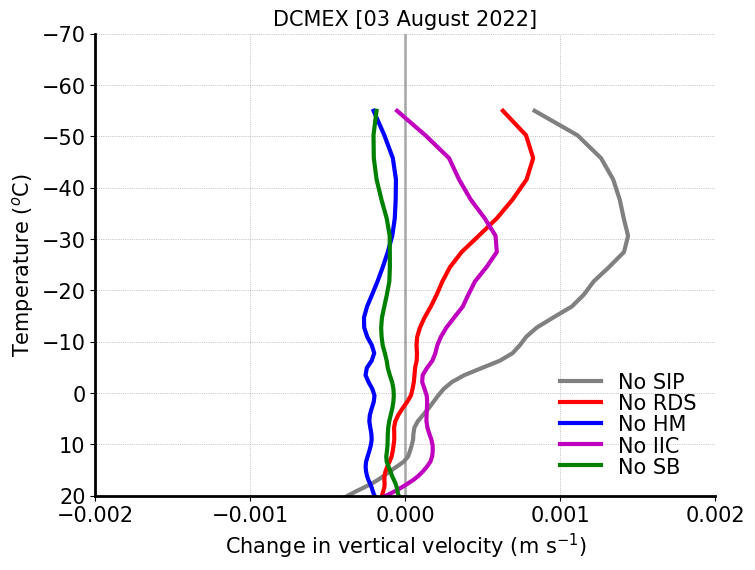

In [47]:


mean_w_net_nosip = ds_nosip.w_vel.mean(dim=('time','ncells'))
mean_w_net_4sip = ds_4sip.w_vel.mean(dim=('time','ncells'))
mean_w_net_norf = ds_norf.w_vel.mean(dim=('time','ncells'))
mean_w_net_nohm = ds_nohm.w_vel.mean(dim=('time','ncells'))
mean_w_net_nobr = ds_nobr.w_vel.mean(dim=('time','ncells'))
mean_w_net_nosb = ds_nosb.w_vel.mean(dim=('time','ncells'))

mean_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_w_net_nosip = mean_omega_net_nosip.where(mean_tempc > -60)
mean_w_net_4sip = mean_omega_net_4sip.where(mean_tempc > -60)
mean_w_net_norf = mean_omega_net_norf.where(mean_tempc > -60)
mean_w_net_nohm = mean_omega_net_nohm.where(mean_tempc > -60)
mean_w_net_nobr = mean_omega_net_nobr.where(mean_tempc > -60)
mean_w_net_nosb = mean_omega_net_nosb.where(mean_tempc > -60)

del_w_nosip = mean_w_net_4sip - mean_w_net_nosip
del_w_norf = mean_w_net_4sip - mean_w_net_norf
del_w_nohm = mean_w_net_4sip - mean_w_net_nohm
del_w_nobr = mean_w_net_4sip - mean_w_net_nobr
del_w_nosb = mean_w_net_4sip - mean_w_net_nosb

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_w_nosip, mean_tempc, '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_w_norf, mean_tempc, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(del_w_nohm, mean_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_w_nobr, mean_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_w_nosb, mean_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-0.002, 0.002)
plt.ylim(20, -70)
plt.xticks([-0.002, -0.001, 0., 0.001, 0.002], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in vertical velocity (m s$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [03 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()



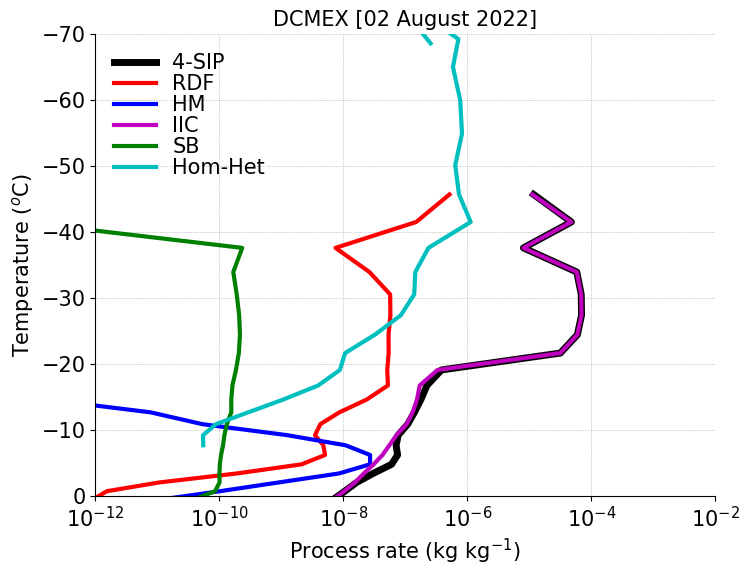

In [14]:

thres_q = 1.e-12
qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_sec, np.nan)
dqi_sec_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_ds, np.nan)
dqi_rf_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_rs, np.nan)
dqi_hm_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_br, np.nan)
dqi_br_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_snow_sbf, np.nan)
dqi_snow_sb = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqi_graup_sbf, np.nan)
dqi_graup_sb = qi_filt.mean(dim=('time','ncells'))

dqi_tot_sb = dqi_snow_sb + dqi_graup_sb

qi_filt = xr.where(ds_4sip.d_qi_homhet > thres_q, ds_4sip.d_qi_homhet, np.nan)
dqi_homhet_tot = qi_filt.mean(dim=('time', 'ncells'))


avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


dqi_sec_tot = dqi_sec_tot.where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.where(avg_tempc > -50)

dqi_sec_tot = dqi_sec_tot.values #where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.values   #where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.values   #where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.values   #where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.values   #where(avg_tempc > -50)
dqi_homhet_tot = dqi_homhet_tot.values
avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(dqi_sec_tot, avg_tempc, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(dqi_rf_tot, avg_tempc, 'r-', linewidth=lnwdth, label='RDF')
plt.plot(dqi_hm_tot, avg_tempc, 'b-', linewidth=lnwdth, label='HM')
plt.plot(dqi_br_tot, avg_tempc, 'm-', linewidth=lnwdth, label='IIC')
plt.plot(dqi_tot_sb, avg_tempc, 'g-', linewidth=lnwdth, label='SB')
plt.plot(dqi_homhet_tot, avg_tempc, 'c-', linewidth=lnwdth, label='Hom-Het')

plt.xscale('log')
plt.xlim(1.e-12, 1.e-2)
plt.ylim(0, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [02 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


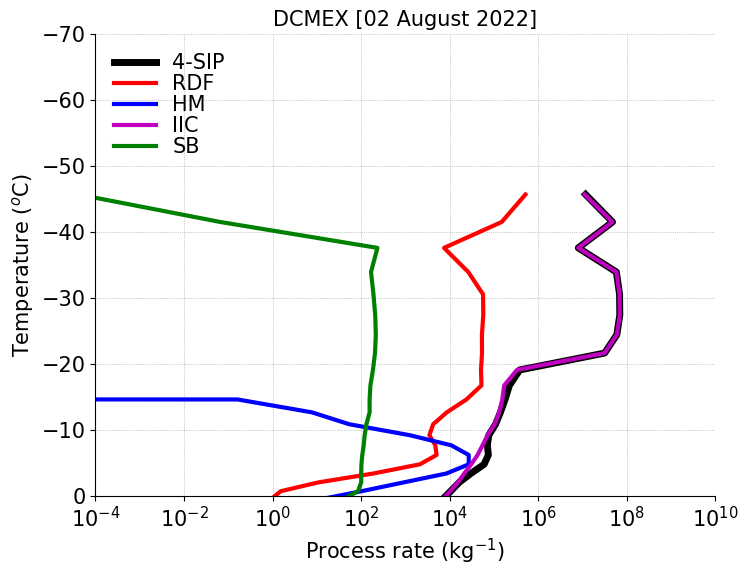

In [27]:

thres_q = 1.e-12
qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_sec, np.nan)
dqi_sec_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_ds, np.nan)
dqi_rf_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_rs, np.nan)
dqi_hm_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_br, np.nan)
dqi_br_tot = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_snow_sbf, np.nan)
dqi_snow_sb = qi_filt.mean(dim=('time','ncells'))

qi_filt = xr.where(ds_4sip.dqi_sec > thres_q, ds_4sip.dqni_graup_sbf, np.nan)
dqi_graup_sb = qi_filt.mean(dim=('time','ncells'))

dqi_tot_sb = dqi_snow_sb + dqi_graup_sb

qi_filt = xr.where(ds_4sip.d_qi_homhet > thres_q, ds_4sip.d_qi_homhet, np.nan)
dqi_homhet_tot = qi_filt.mean(dim=('time', 'ncells'))


avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


dqi_sec_tot = dqi_sec_tot.where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.where(avg_tempc > -50)

dqi_sec_tot = dqi_sec_tot.values #where(avg_tempc > -50)
dqi_rf_tot = dqi_rf_tot.values   #where(avg_tempc > -50)
dqi_hm_tot = dqi_hm_tot.values   #where(avg_tempc > -50)
dqi_br_tot = dqi_br_tot.values   #where(avg_tempc > -50)
dqi_tot_sb = dqi_tot_sb.values   #where(avg_tempc > -50)
dqi_homhet_tot = dqi_homhet_tot.values
avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;
st = 3
plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(dqi_sec_tot, avg_tempc, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(dqi_rf_tot, avg_tempc, 'r-', linewidth=lnwdth, label='RDF')
plt.plot(dqi_hm_tot, avg_tempc, 'b-', linewidth=lnwdth, label='HM')
plt.plot(dqi_br_tot, avg_tempc, 'm-', linewidth=lnwdth, label='IIC')
plt.plot(dqi_tot_sb, avg_tempc, 'g-', linewidth=lnwdth, label='SB')
#plt.plot(dqi_homhet_tot, avg_tempc, 'c-', linewidth=lnwdth, label='Hom-Het')

plt.xscale('log')
plt.xlim(1.e-4, 1.e10)
plt.ylim(0, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [02 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()


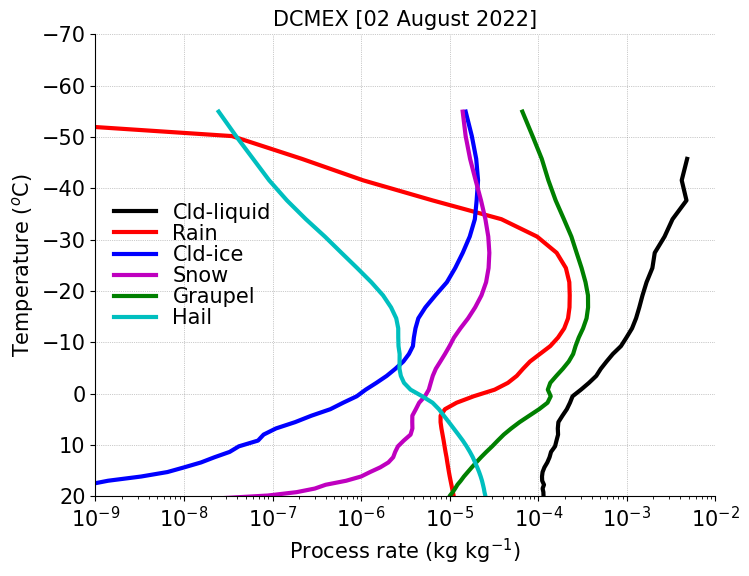

In [21]:

thres_q = 1.e-12
filt_q = xr.where(ds_4sip.qr > thres_q, ds_4sip.qr, np.nan)
avg_qr = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qc > thres_q, ds_4sip.qc, np.nan)
avg_qc = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qi > thres_q, ds_4sip.qi, np.nan)
avg_qi = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qs > thres_q, ds_4sip.qs, np.nan)
avg_qs = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qg, np.nan)
avg_qg = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qh, np.nan)
avg_qh = filt_q.mean(dim=('time','ncells'))

avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

avg_qr = avg_qr.where(avg_tempc > -60)
avg_qc = avg_qc.where(avg_tempc > -60)
avg_qi = avg_qi.where(avg_tempc > -60)
avg_qs = avg_qs.where(avg_tempc > -60)
avg_qg = avg_qg.where(avg_tempc > -60)
avg_qh = avg_qh.where(avg_tempc > -60)

avg_qr = avg_qr.values
avg_qc = avg_qc.values
avg_qi = avg_qi.values
avg_qs = avg_qs.values
avg_qg = avg_qg.values
avg_qh = avg_qh.values

avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(avg_qc, avg_tempc, 'k-', linewidth=lnwdth, label='Cld-liquid')
plt.plot(avg_qr, avg_tempc, 'r-', linewidth=lnwdth, label='Rain')
plt.plot(avg_qi, avg_tempc, 'b-', linewidth=lnwdth, label='Cld-ice')
plt.plot(avg_qs, avg_tempc, 'm-', linewidth=lnwdth, label='Snow')
plt.plot(avg_qg, avg_tempc, 'g-', linewidth=lnwdth, label='Graupel')
plt.plot(avg_qh, avg_tempc, 'c-', linewidth=lnwdth, label='Hail')

plt.xscale('log')
plt.xlim(1.e-9, 1.e-2)
plt.ylim(20, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [02 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='best')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()

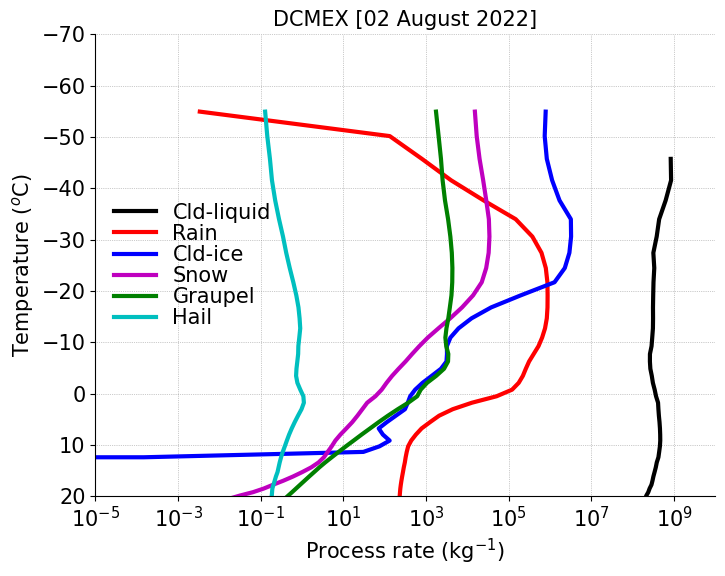

In [23]:

thres_q = 1.e-12
filt_q = xr.where(ds_4sip.qr > thres_q, ds_4sip.qnr, np.nan)
avg_qnr = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qc > thres_q, ds_4sip.qnc, np.nan)
avg_qnc = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qi > thres_q, ds_4sip.qni, np.nan)
avg_qni = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qs > thres_q, ds_4sip.qns, np.nan)
avg_qns = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qng, np.nan)
avg_qng = filt_q.mean(dim=('time','ncells'))

filt_q = xr.where(ds_4sip.qh > thres_q, ds_4sip.qnh, np.nan)
avg_qnh = filt_q.mean(dim=('time','ncells'))

avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

avg_qnr = avg_qnr.where(avg_tempc > -60)
avg_qnc = avg_qnc.where(avg_tempc > -60)
avg_qni = avg_qni.where(avg_tempc > -60)
avg_qns = avg_qns.where(avg_tempc > -60)
avg_qng = avg_qng.where(avg_tempc > -60)
avg_qnh = avg_qnh.where(avg_tempc > -60)

avg_qnr = avg_qnr.values
avg_qnc = avg_qnc.values
avg_qni = avg_qni.values
avg_qns = avg_qns.values
avg_qng = avg_qng.values
avg_qnh = avg_qnh.values

avg_tempc = avg_tempc.values

fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(avg_qnc, avg_tempc, 'k-', linewidth=lnwdth, label='Cld-liquid')
plt.plot(avg_qnr, avg_tempc, 'r-', linewidth=lnwdth, label='Rain')
plt.plot(avg_qni, avg_tempc, 'b-', linewidth=lnwdth, label='Cld-ice')
plt.plot(avg_qns, avg_tempc, 'm-', linewidth=lnwdth, label='Snow')
plt.plot(avg_qng, avg_tempc, 'g-', linewidth=lnwdth, label='Graupel')
plt.plot(avg_qnh, avg_tempc, 'c-', linewidth=lnwdth, label='Hail')

plt.xscale('log')
plt.xlim(1.e-5, 1.e10)
plt.ylim(20, -70)
#plt.xticks([-4, -2, 0, 2, 4, 6, 8, 10], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Process rate (kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('DCMEX [02 August 2022]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='best')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()
